In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
import trimap
import pacmap
import matplotlib as mpl
from matplotlib import cm

In [16]:
random=42

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.data"
df = pd.read_csv(url, header=None)
df = df.apply(lambda x: pd.factorize(x)[0])
X = df.values

In [18]:
scalers = {
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler()
}

scaled_data = {}
scaled_colors = {}

for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    scaled_data[name] = X_scaled
    color = scaler.fit_transform(X[:, [0]])[:, 0]
    scaled_colors[name] = color

In [19]:
# цветовая карта
cmap = getattr(cm, "plasma_r", cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # оси для полного scatter
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # оси для zoom-in scatter
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # ось для colorbar
    left, width = width + left + 0.13, 0.01
    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )

def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="X", x1_label="Y"):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

def make_plot(X, y, title, feature_names=("X1","X2")):
    """
    X: np.ndarray (n_samples,2)
    y: np.ndarray (n_samples,) — цветовая переменная (нормализованная 0-1)
    """
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    plot_distribution(
        ax_zoom_out,
        X,
        y,
        hist_nbins=200,
        x0_label=feature_names[0],
        x1_label=feature_names[1],
        title="Full data",
    )

    # zoom-in: убираем выбросы
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        ax_zoom_in,
        X[mask],
        y[mask],
        hist_nbins=50,
        x0_label=feature_names[0],
        x1_label=feature_names[1],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(vmin=np.min(y), vmax=np.max(y))
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping",
    )
    plt.show()


In [20]:
tsne_params = [
    {"perplexity": 30, "learning_rate": 200},
    {"perplexity": 50, "learning_rate": 100},
    {"perplexity": 10, "learning_rate": 500},
    {"perplexity": 5, "learning_rate": 200},
    {"perplexity": 40, "learning_rate": 300},
    {"perplexity": 20, "learning_rate": 50},
]

umap_params = [
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.1},
    {"n_neighbors": 50, "min_dist": 0.5},
    {"n_neighbors": 10, "min_dist": 0.01},
    {"n_neighbors": 100, "min_dist": 0.2},
    {"n_neighbors": 5, "min_dist": 0.5},
]

trimap_params = [
    {"n_inliers": 10, "n_outliers": 5},
    {"n_inliers": 20, "n_outliers": 10},
    {"n_inliers": 5, "n_outliers": 5},
    {"n_inliers": 50, "n_outliers": 20},
    {"n_inliers": 15, "n_outliers": 5},
    {"n_inliers": 30, "n_outliers": 15},
]

pacmap_params = [
    {"n_neighbors": 10},
    {"n_neighbors": 20},
    {"n_neighbors": 30},
    {"n_neighbors": 50},
    {"n_neighbors": 100},
    {"n_neighbors": 200},
]


=== Масштабирование: MinMax ===


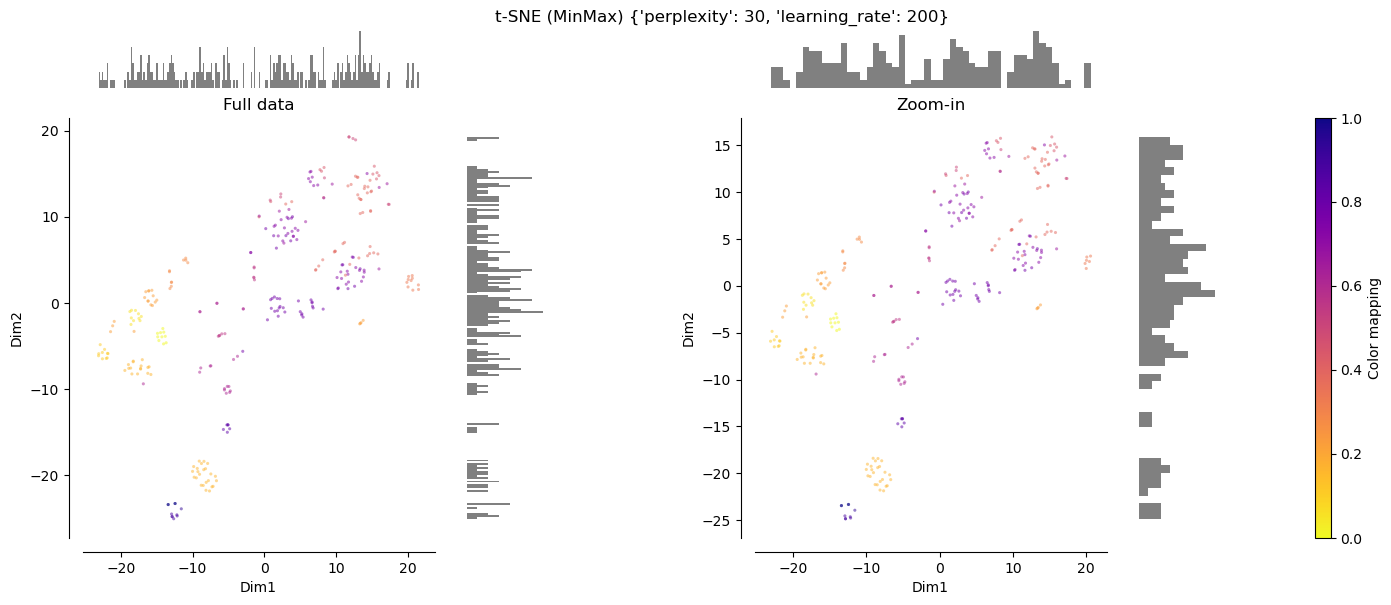

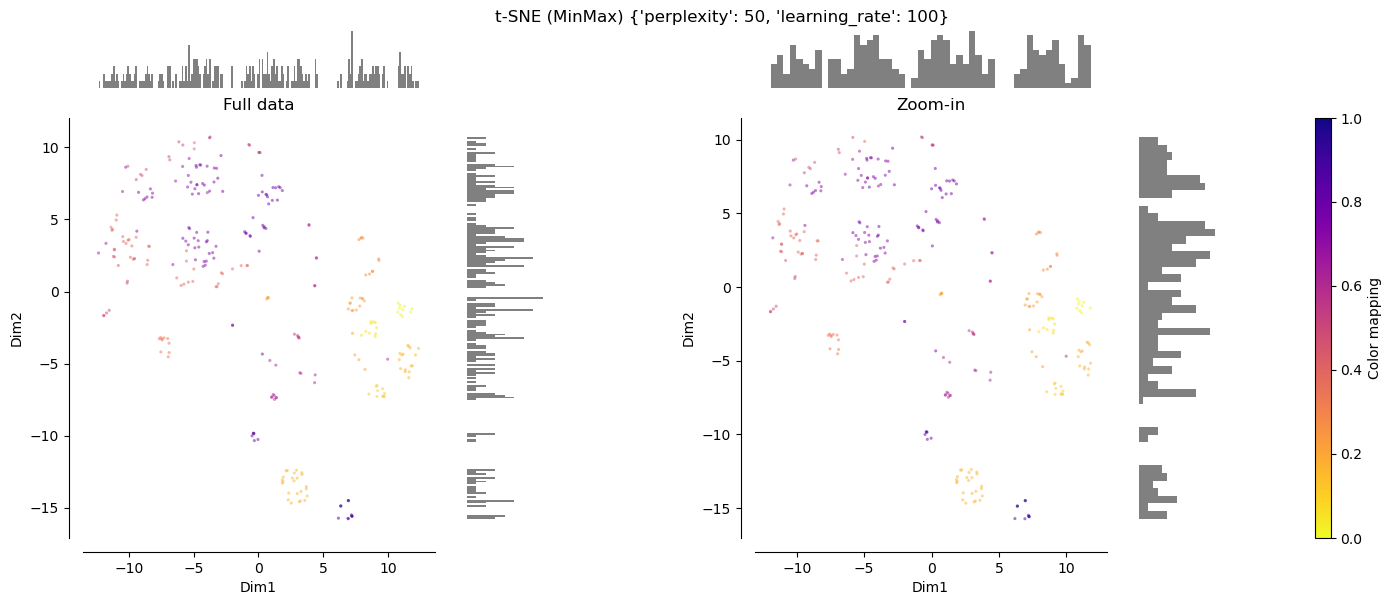

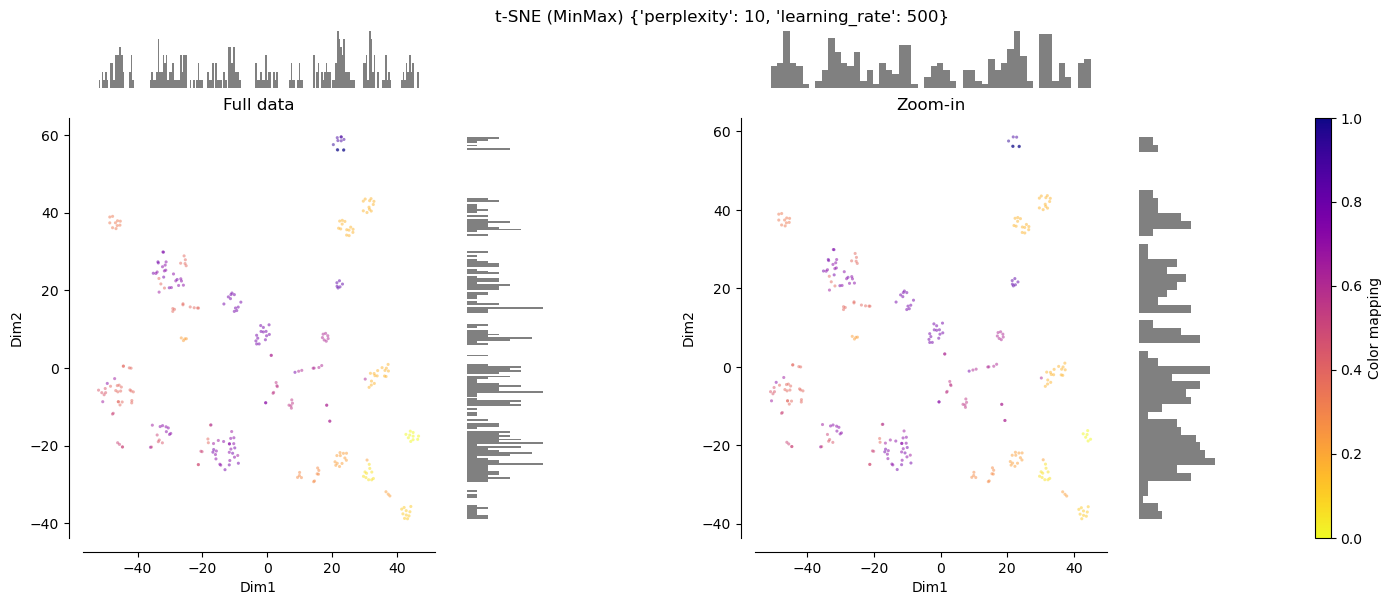

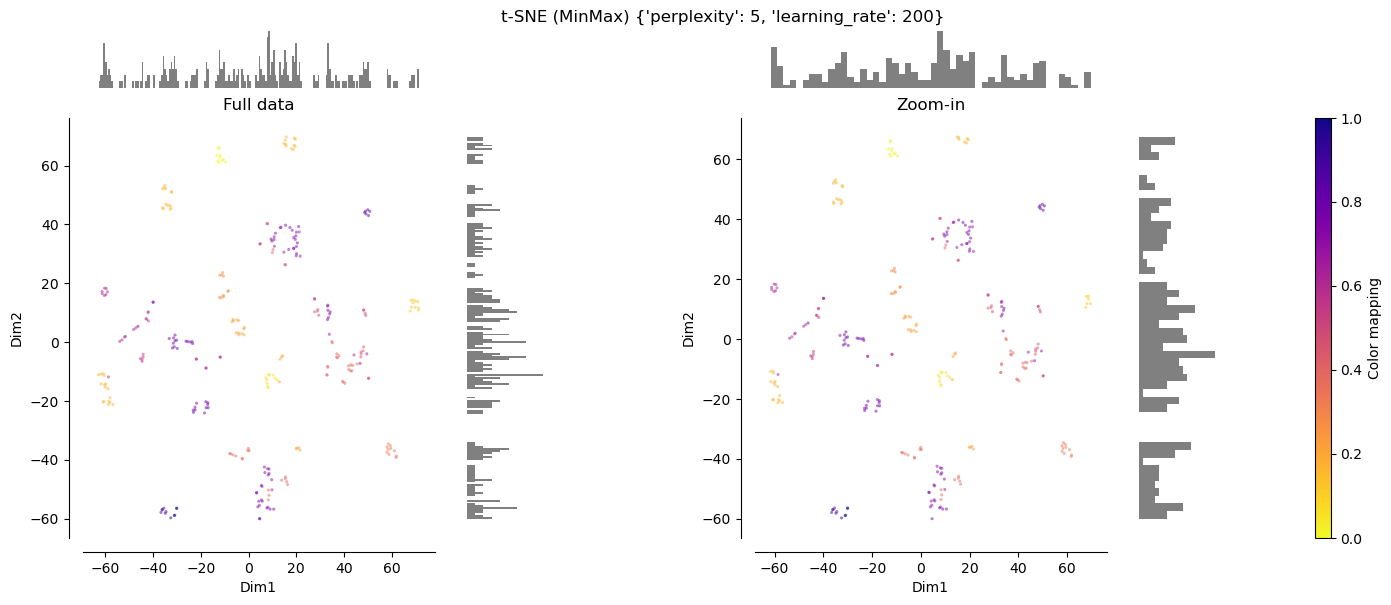

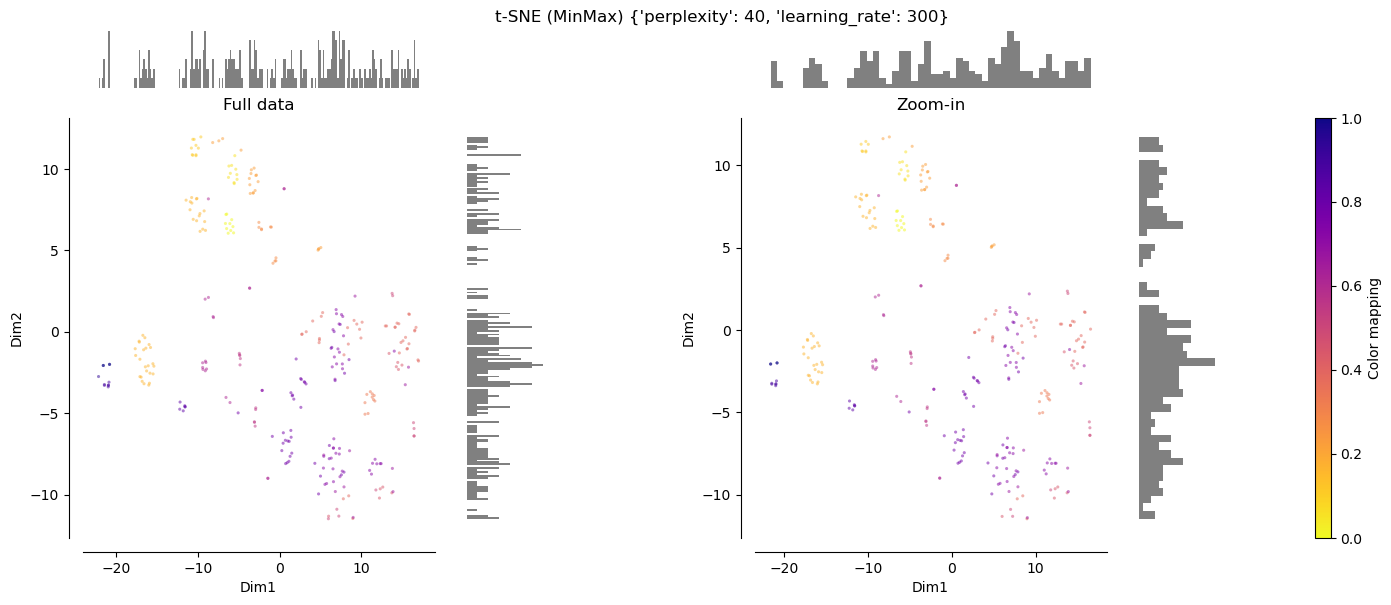

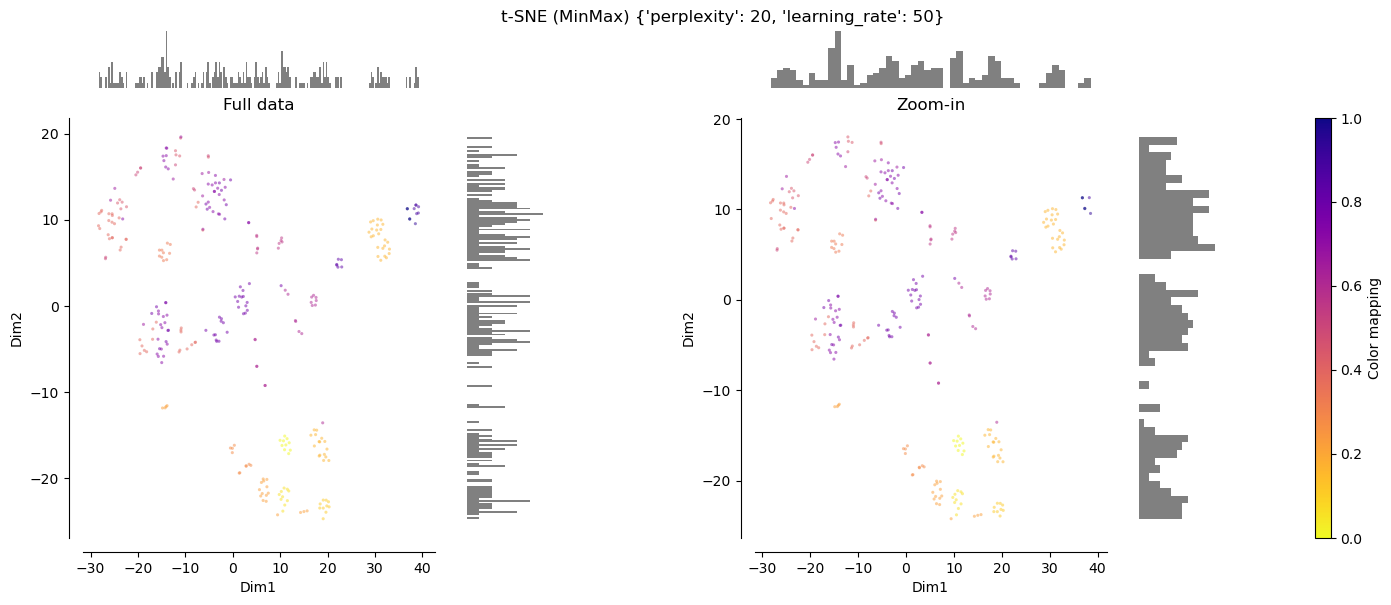


=== Масштабирование: Standard ===


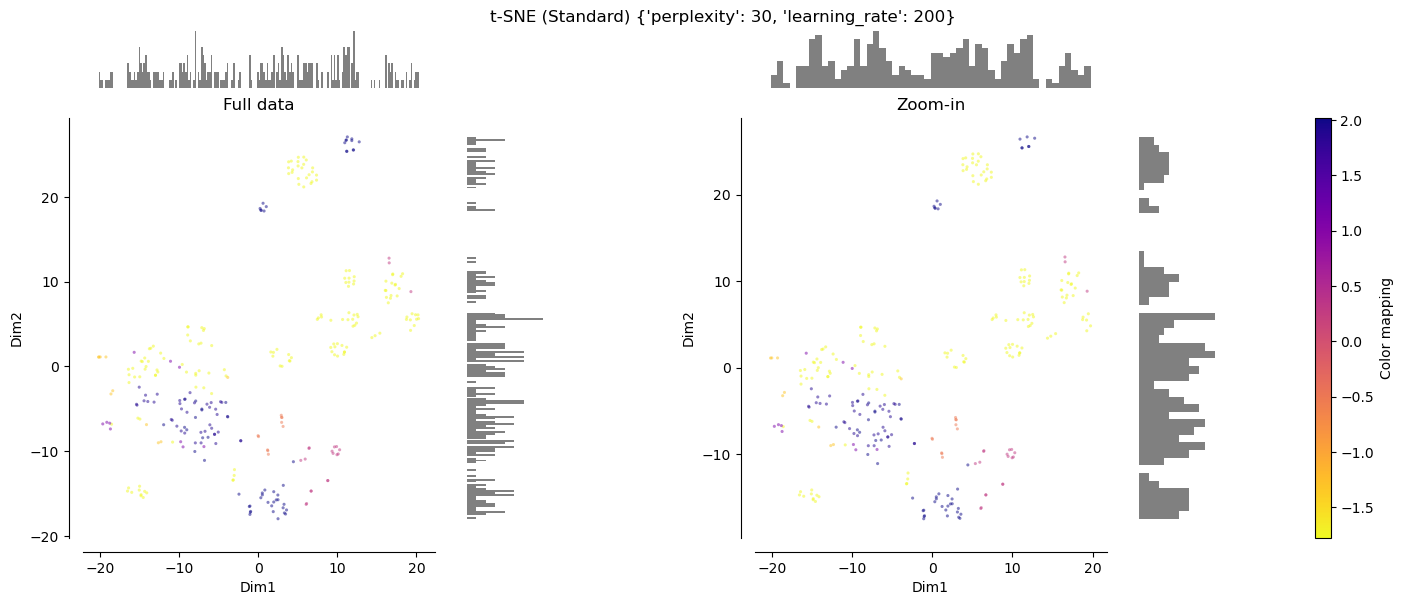

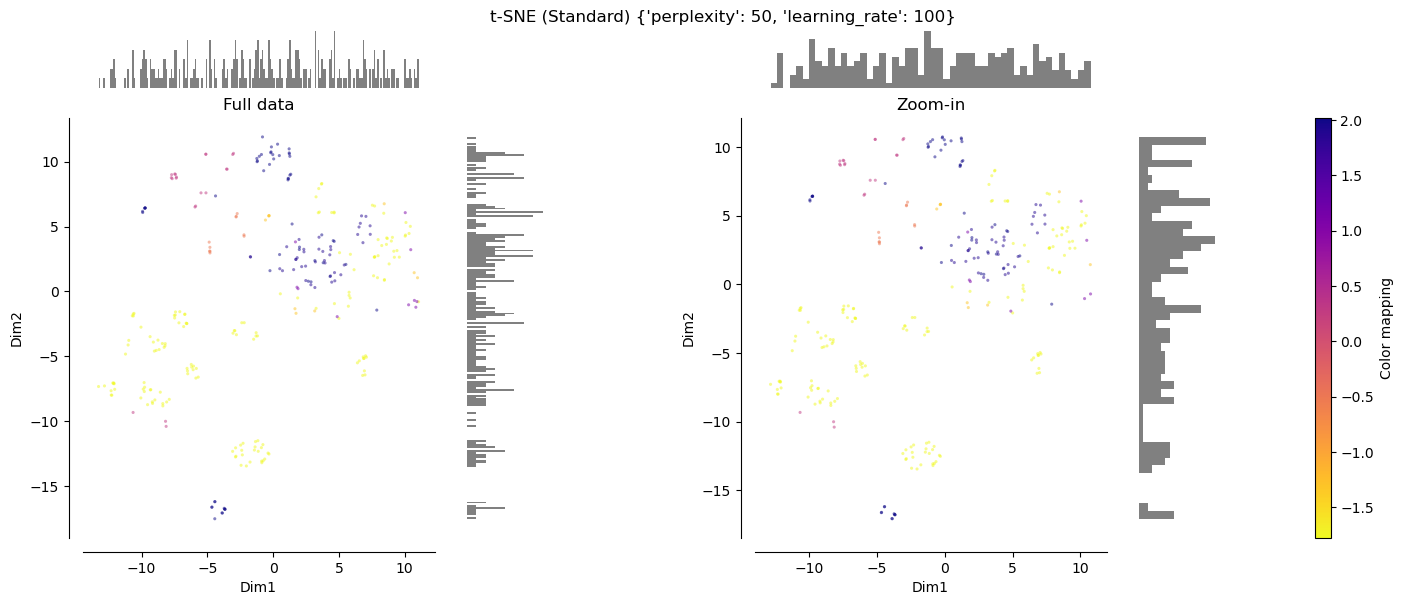

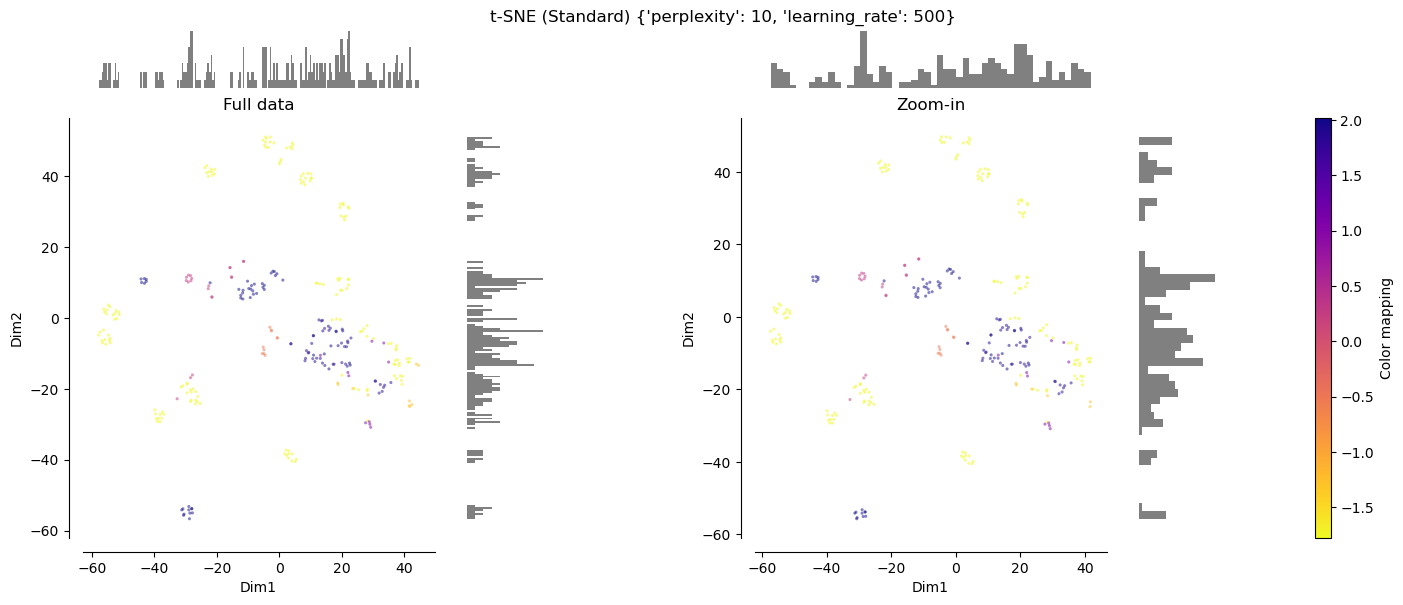

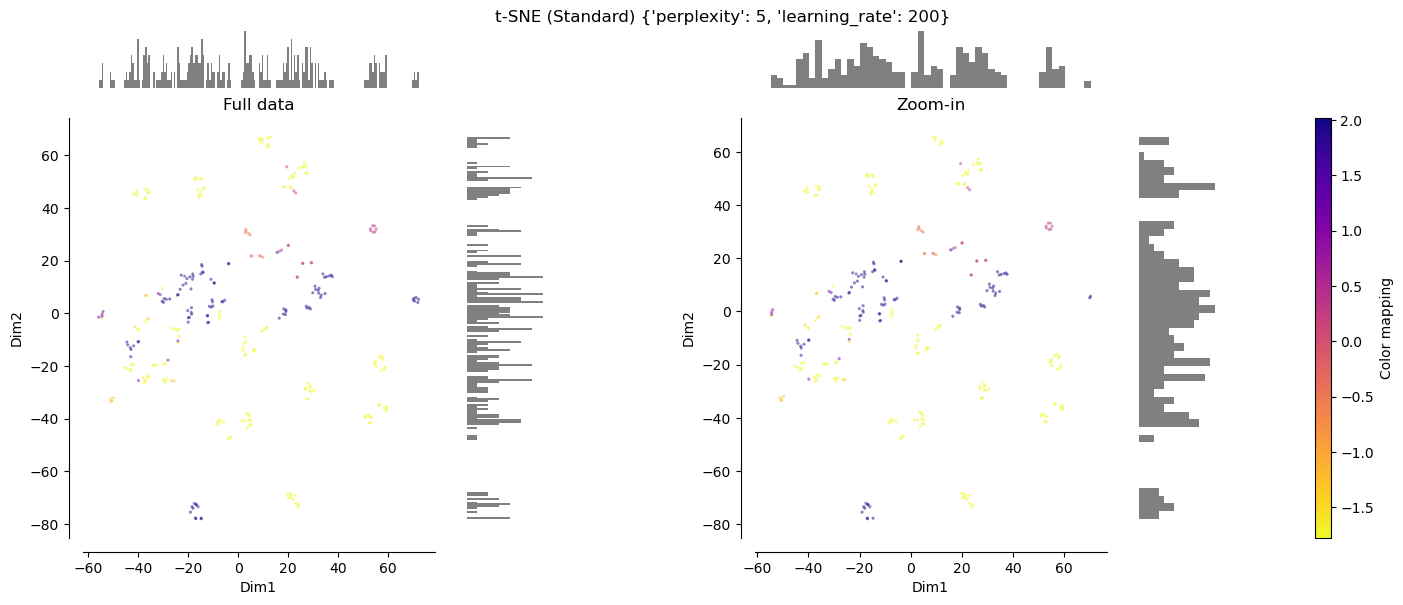

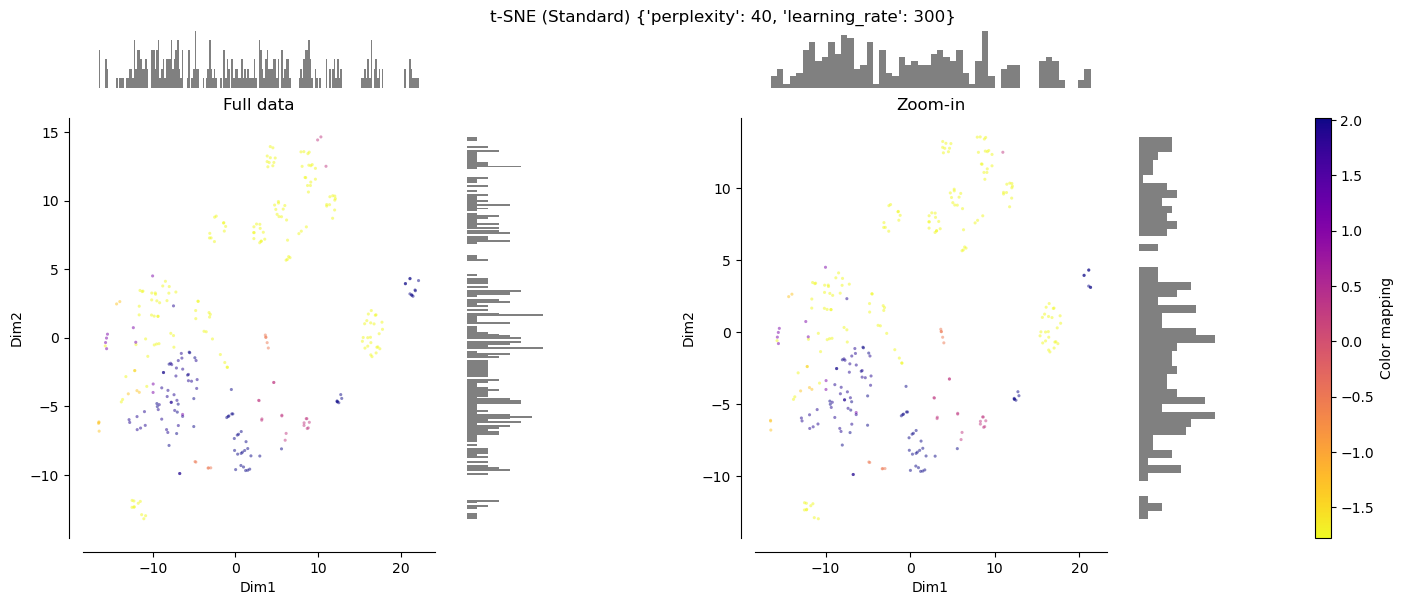

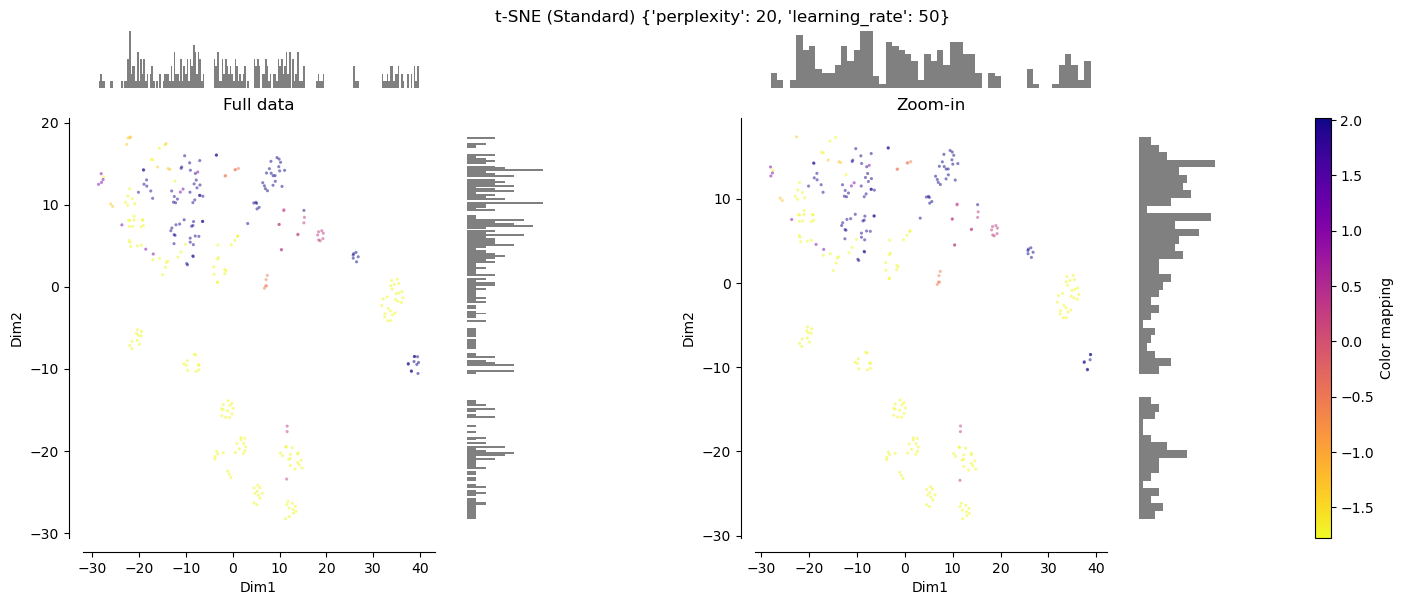


=== Масштабирование: Robust ===


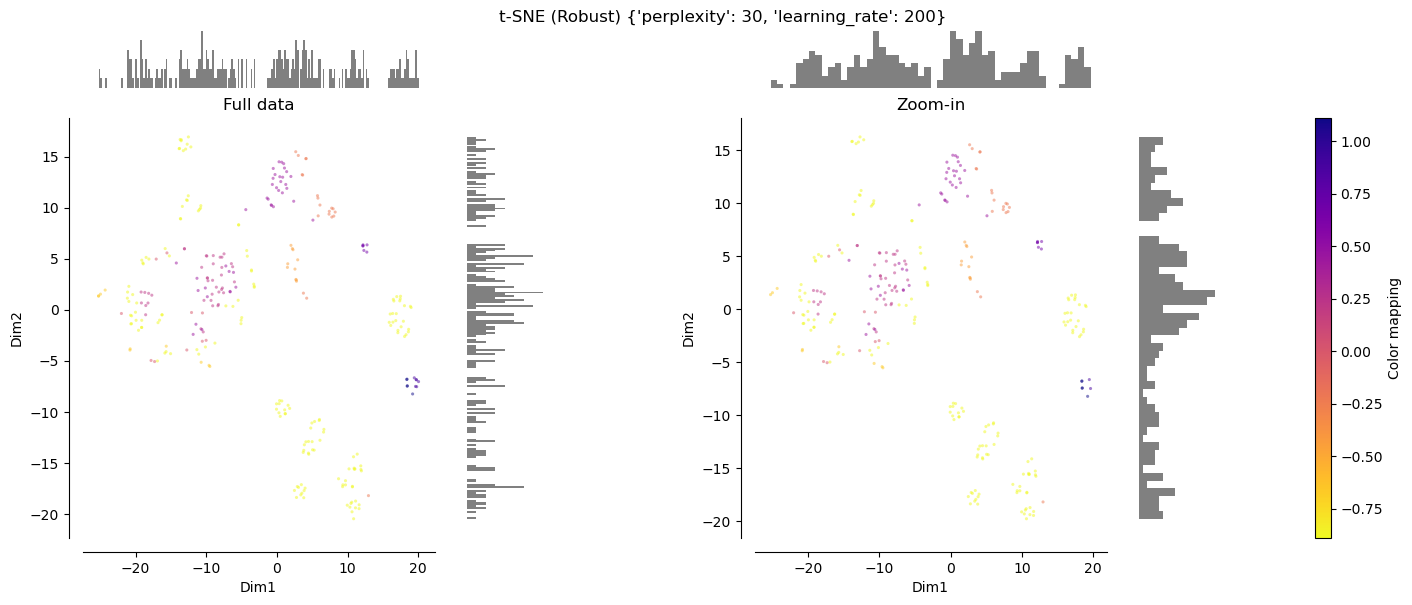

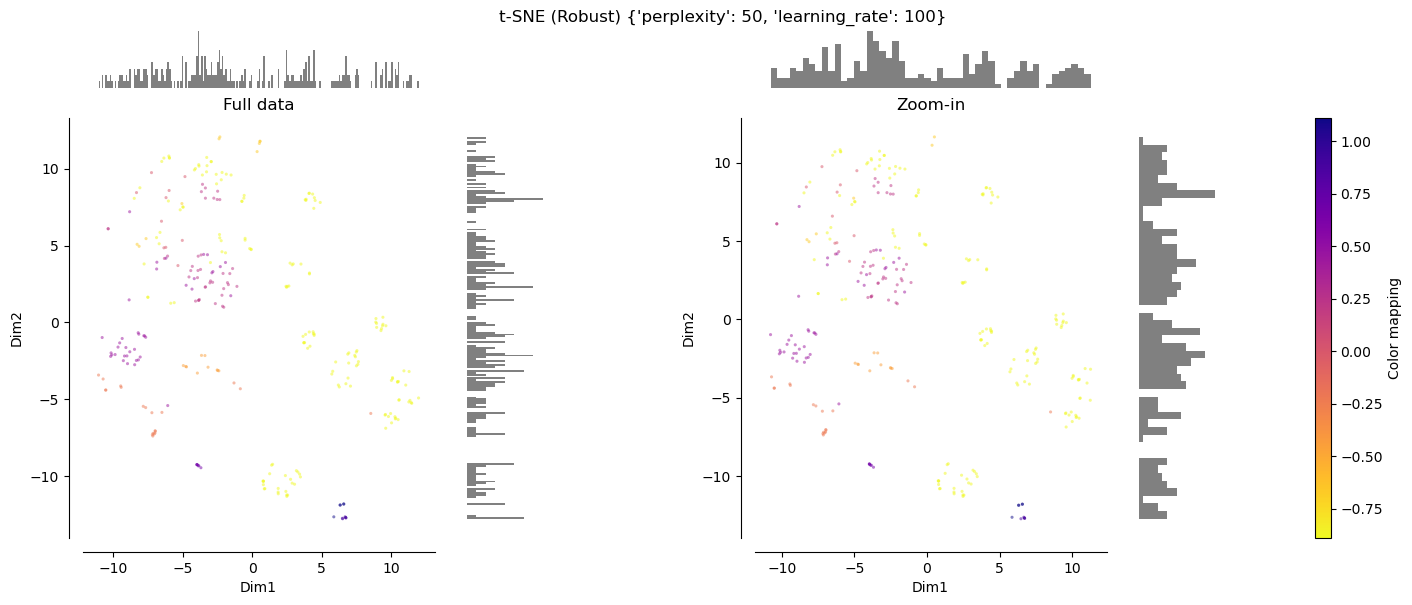

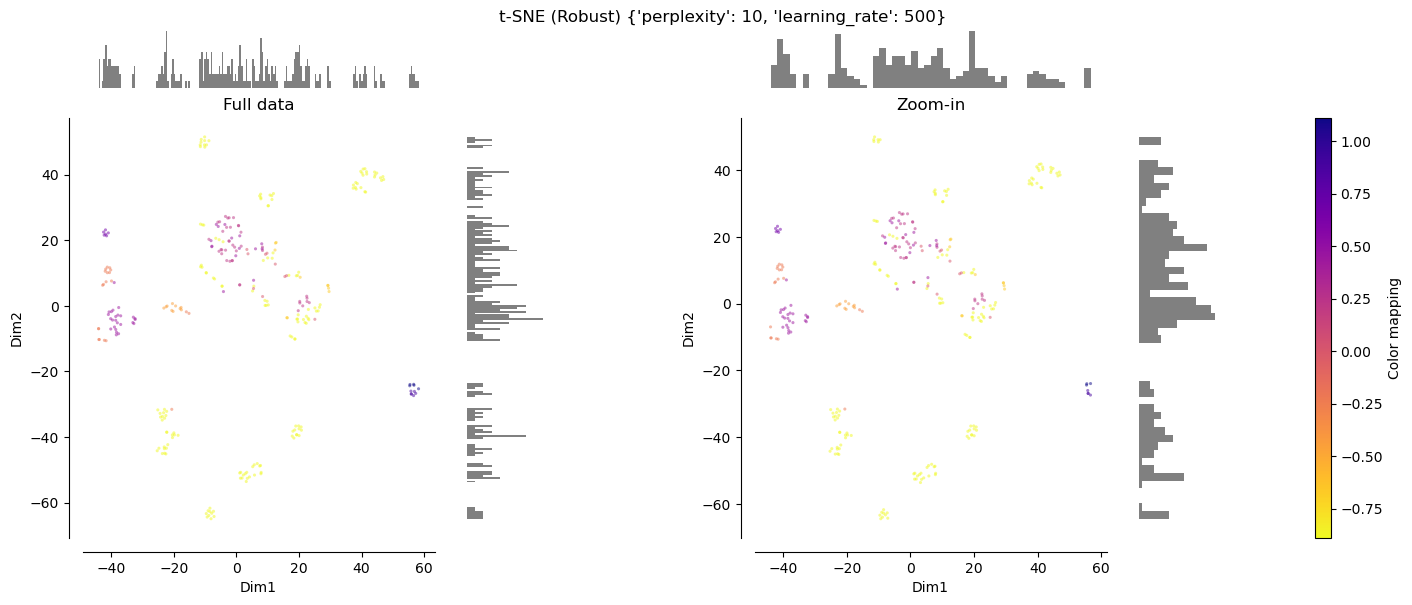

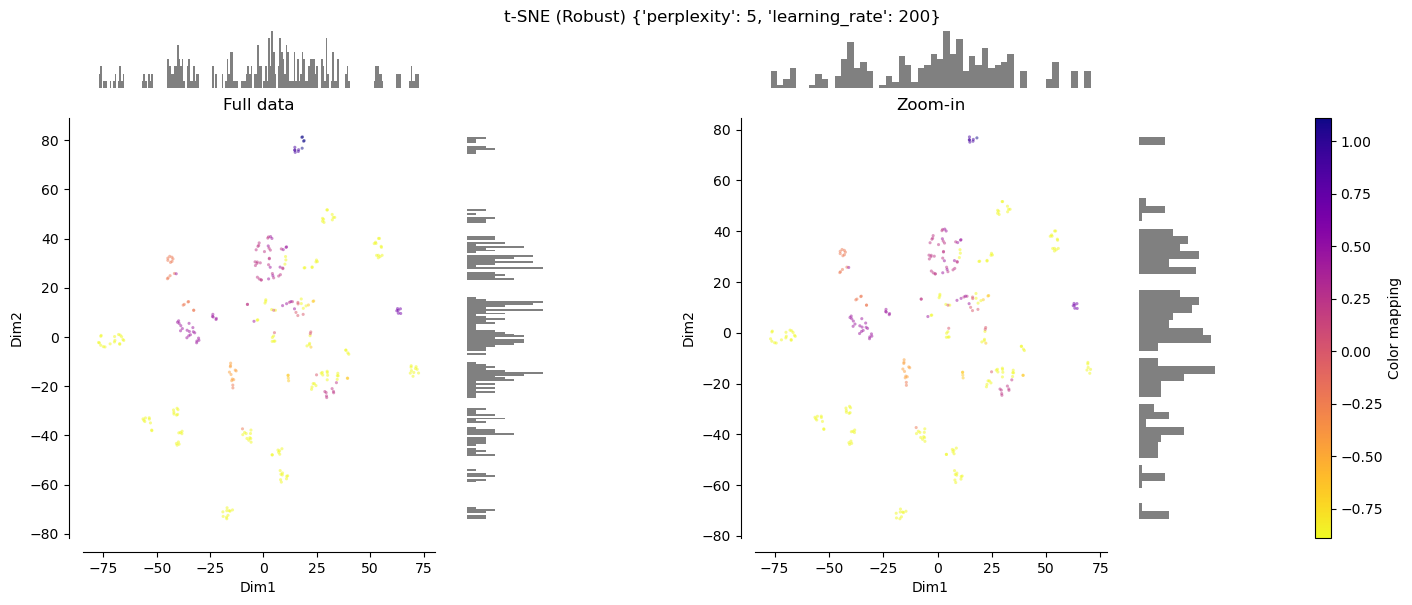

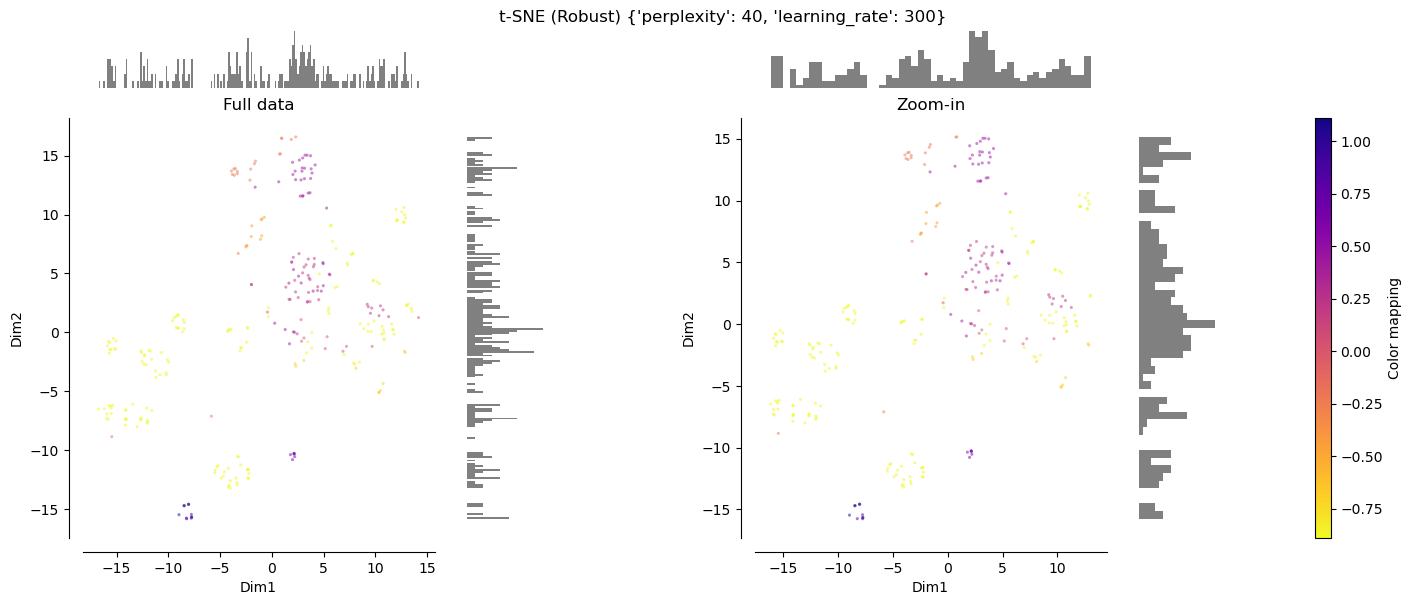

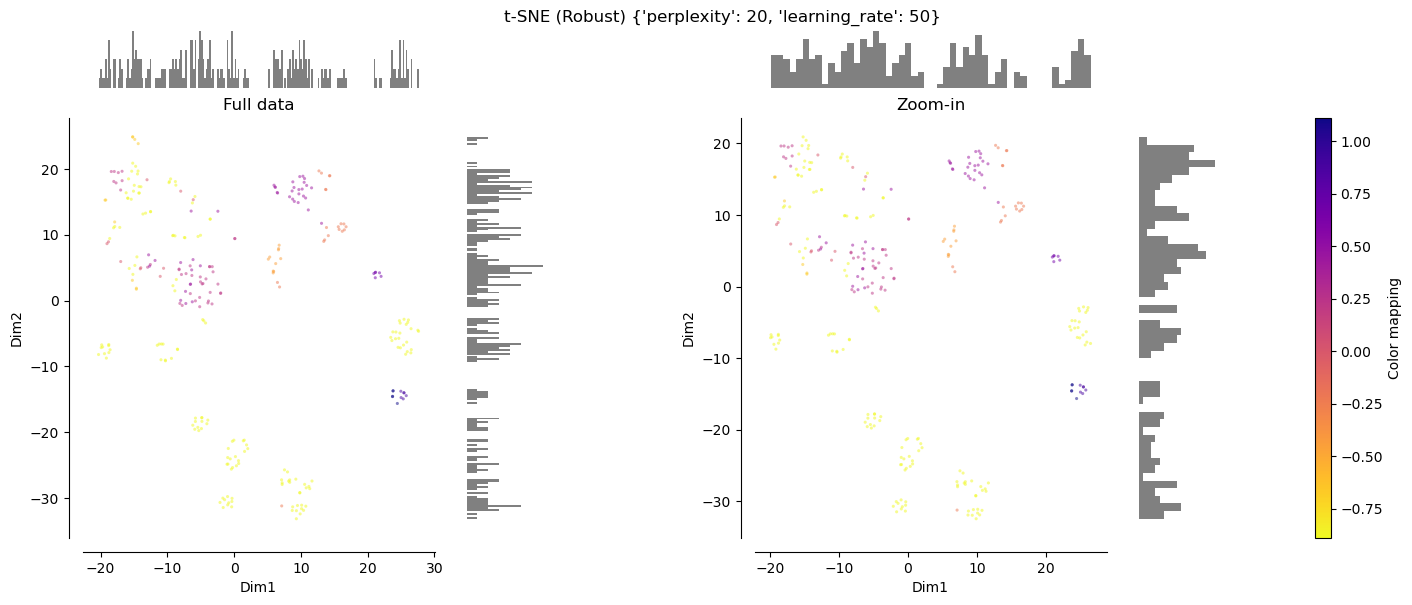

In [21]:
# TSNE
for scale_name in scaled_data.keys():
    X_scaled = scaled_data[scale_name]
    y_color = scaled_colors[scale_name]
    print(f"\n=== Масштабирование: {scale_name} ===")
    for params in tsne_params:
        tsne = TSNE(n_components=2, random_state=random, **params)
        emb = tsne.fit_transform(X_scaled)
        make_plot(
            emb, y_color,
            title=f"t-SNE ({scale_name}) {params}",
            feature_names=("Dim1", "Dim2")
        )


=== Масштабирование: MinMax ===


C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


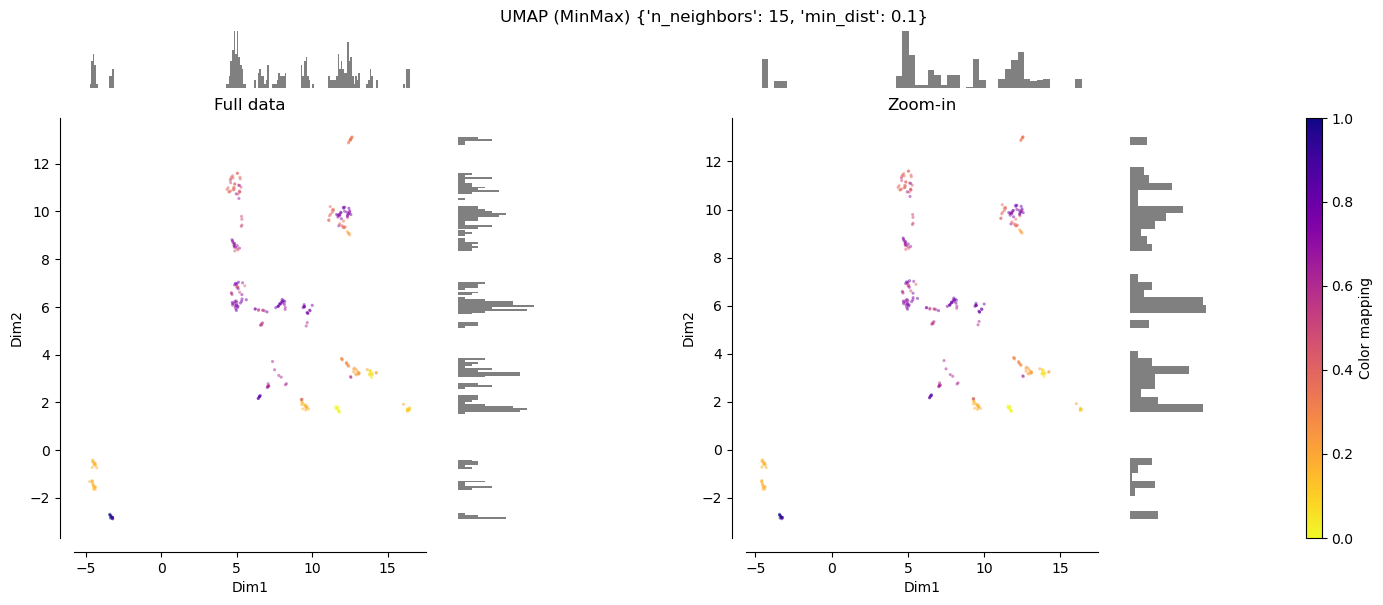

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


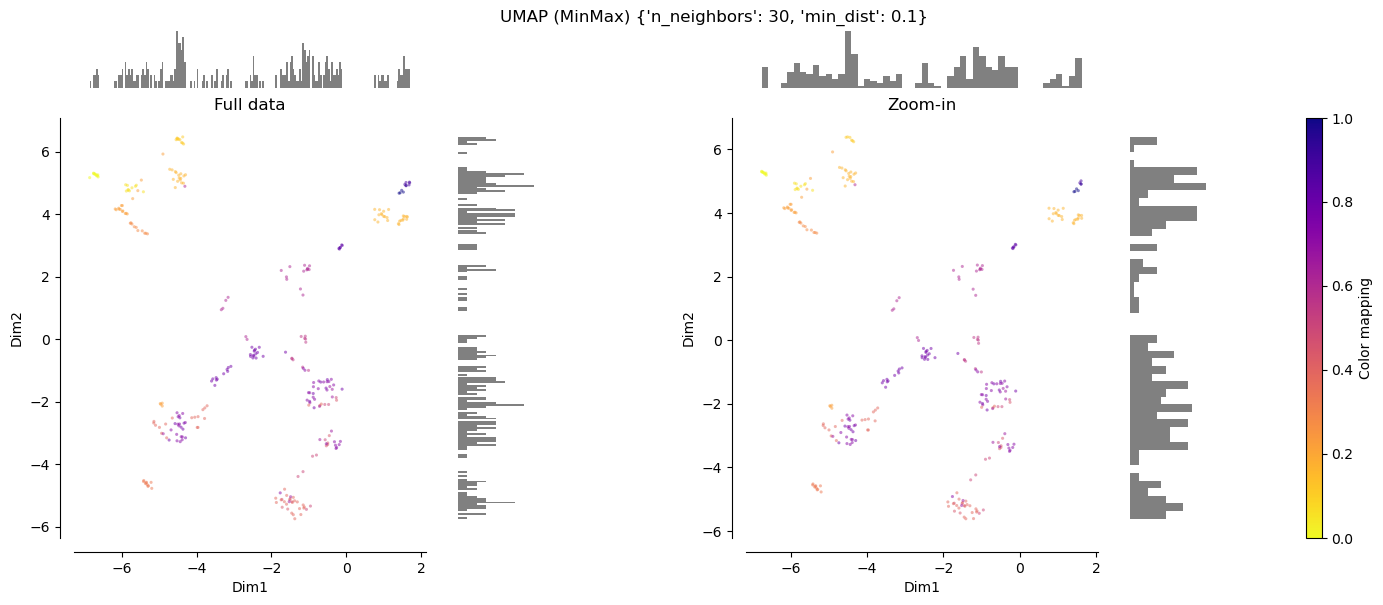

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


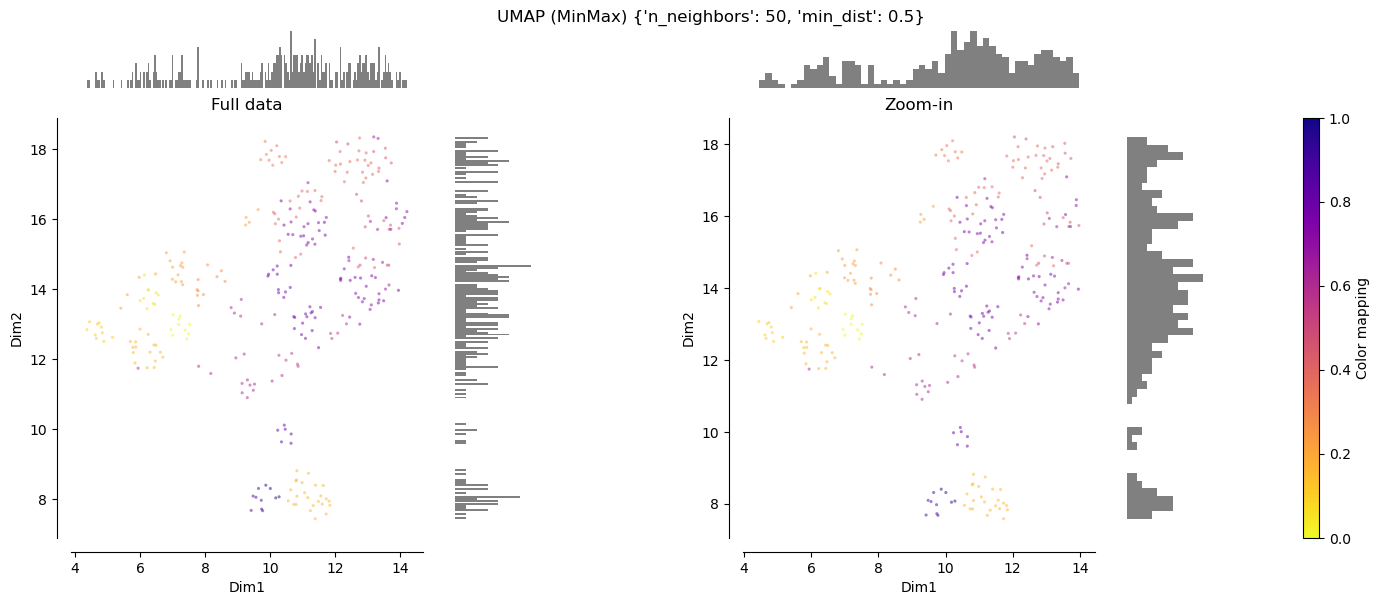

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


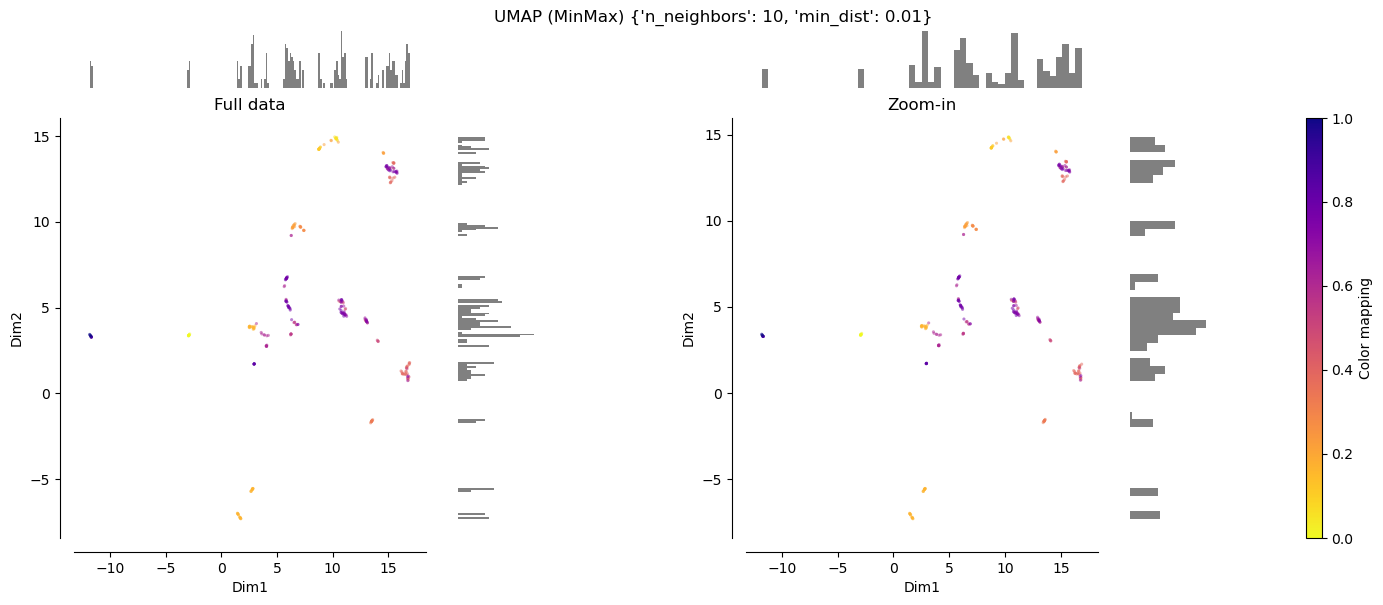

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


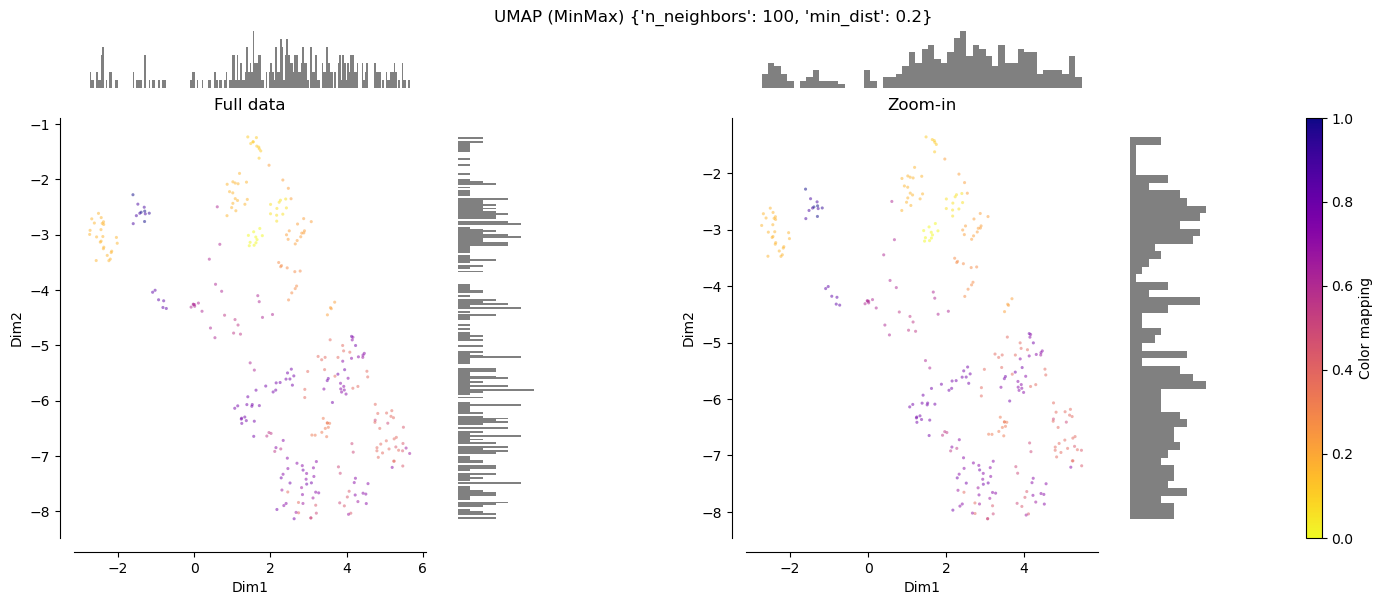

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


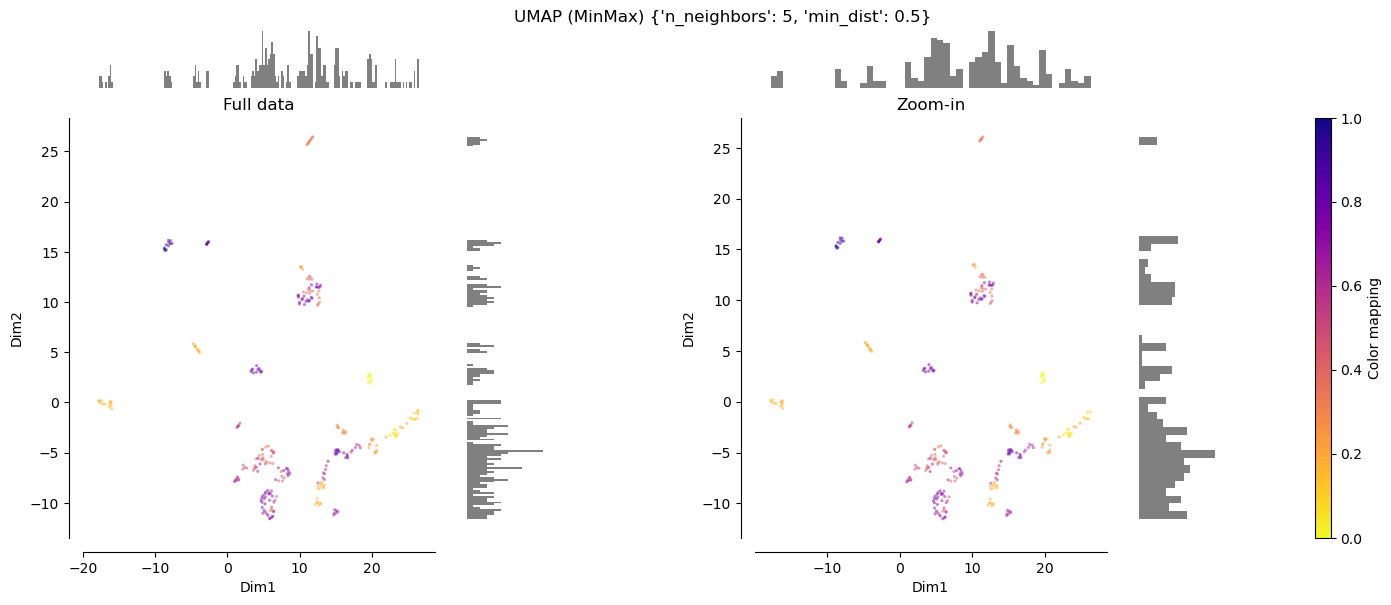


=== Масштабирование: Standard ===


C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


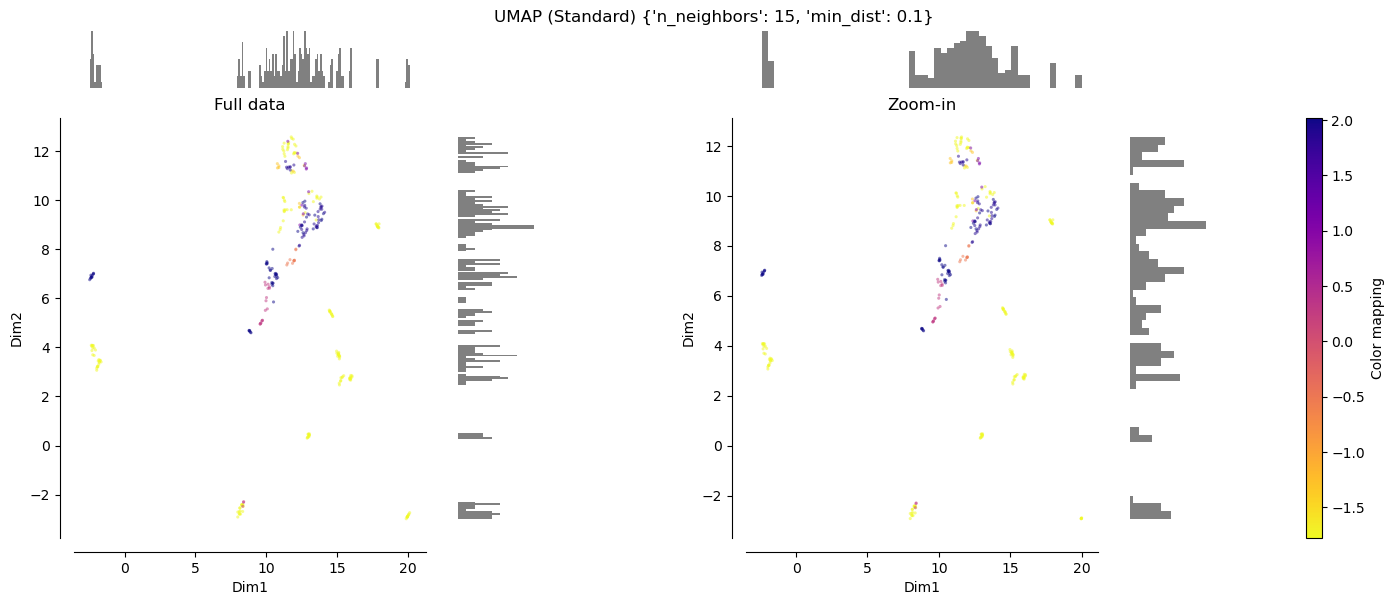

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


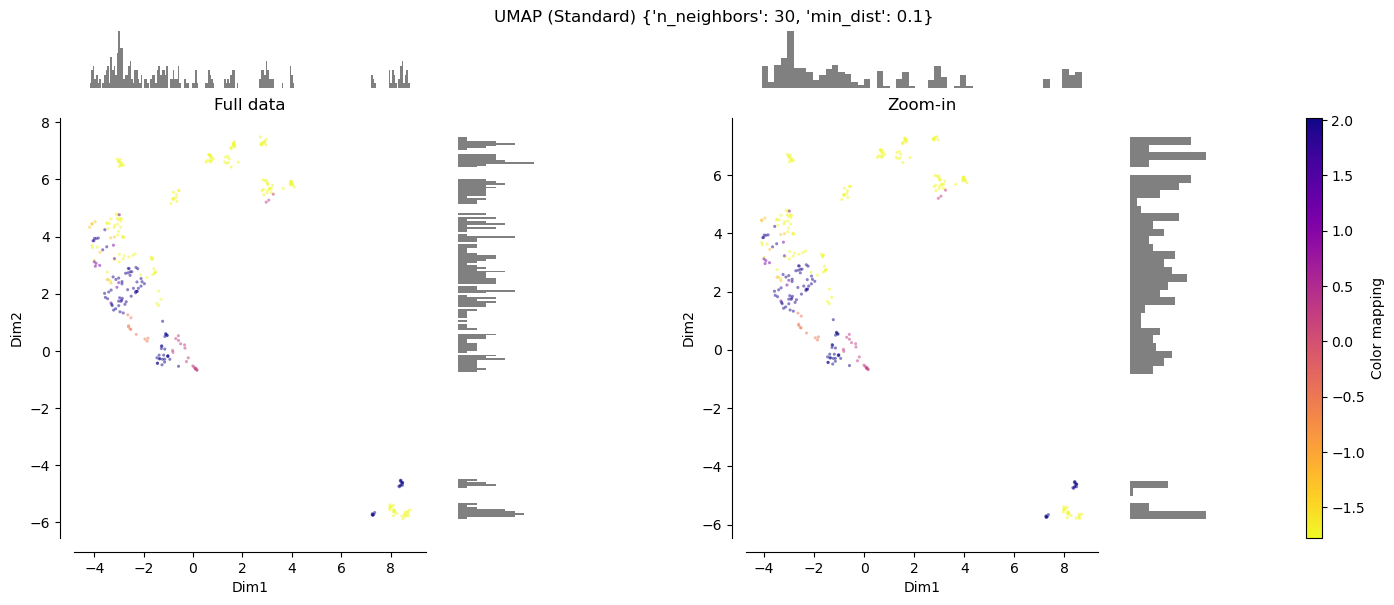

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


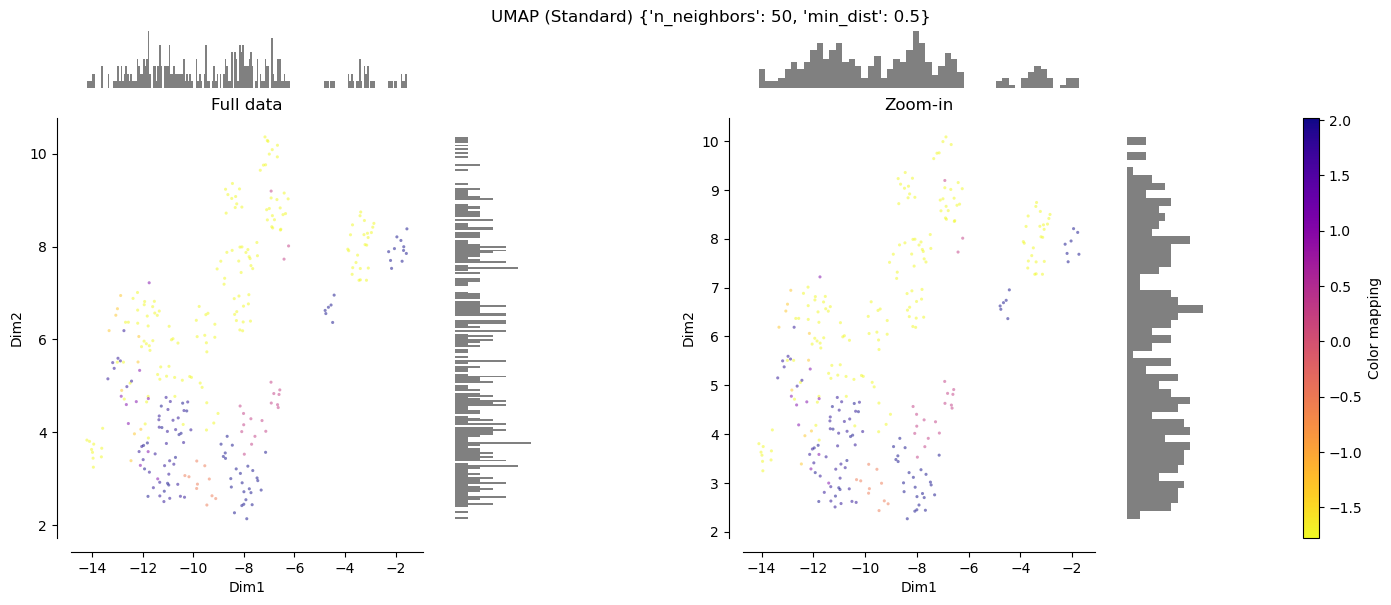

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


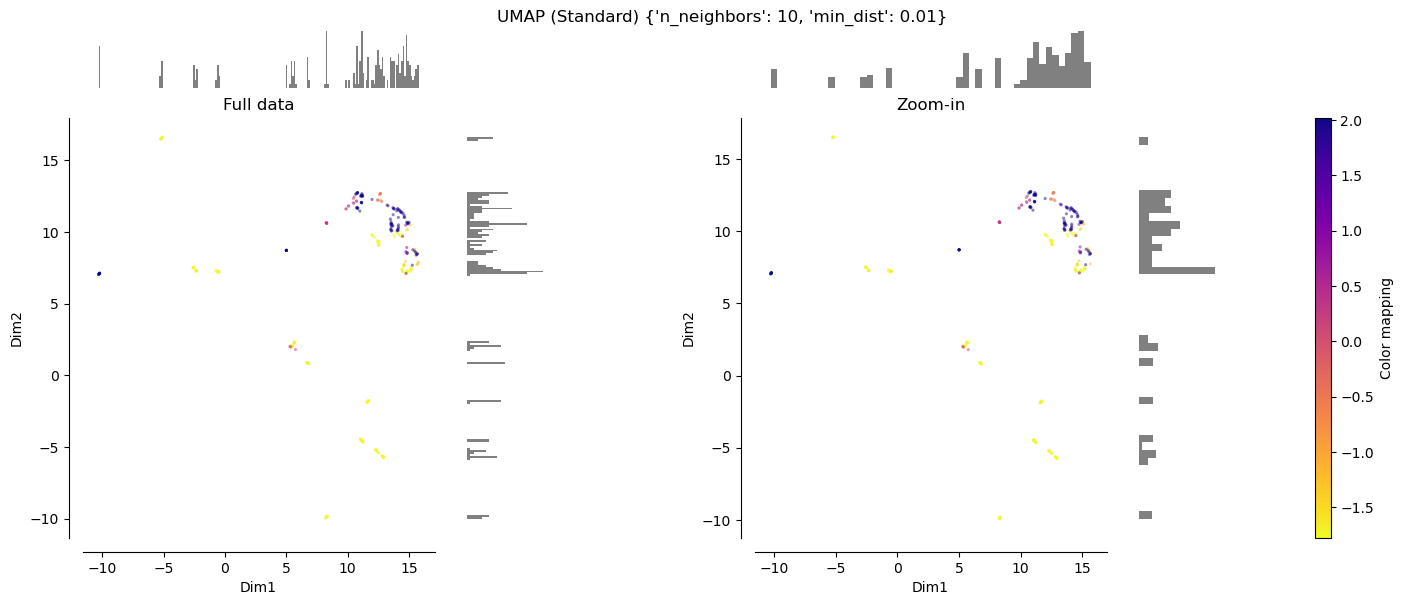

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


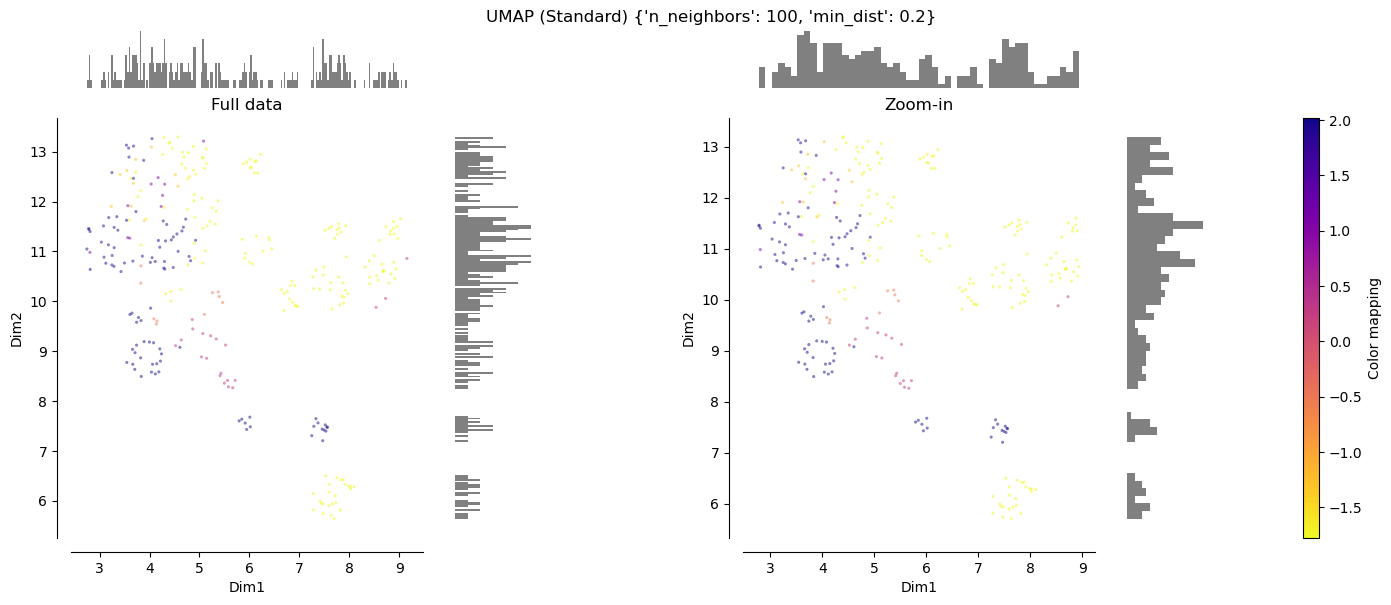

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


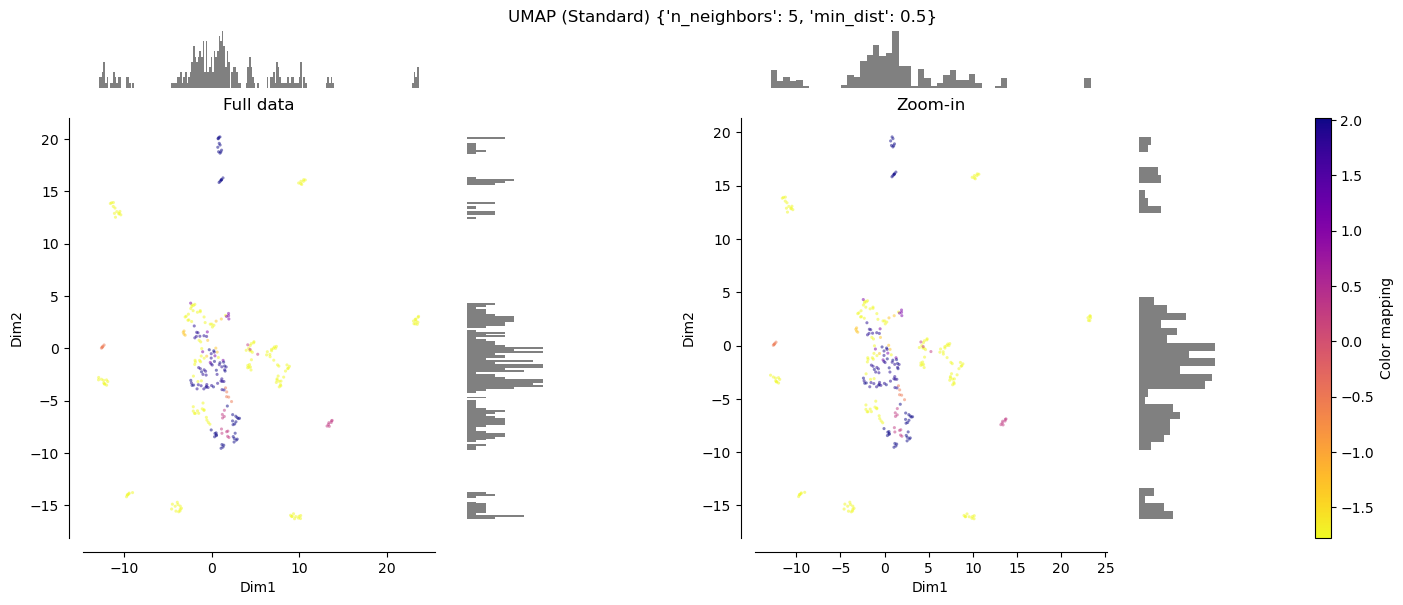


=== Масштабирование: Robust ===


C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


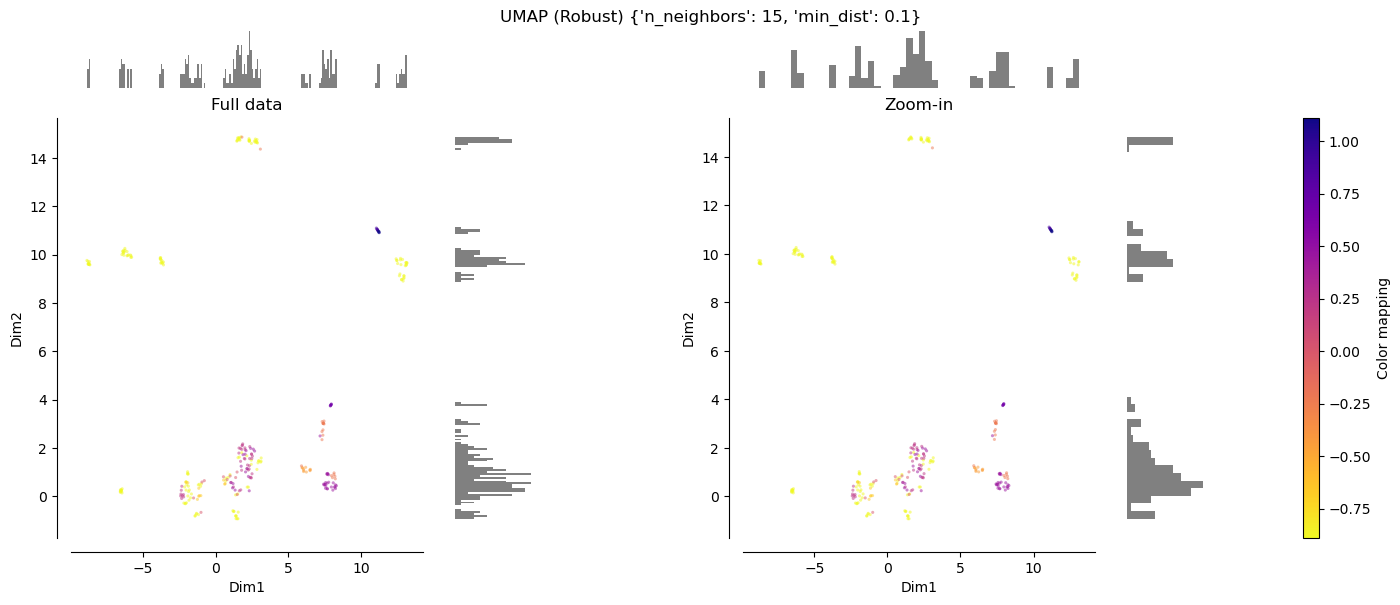

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


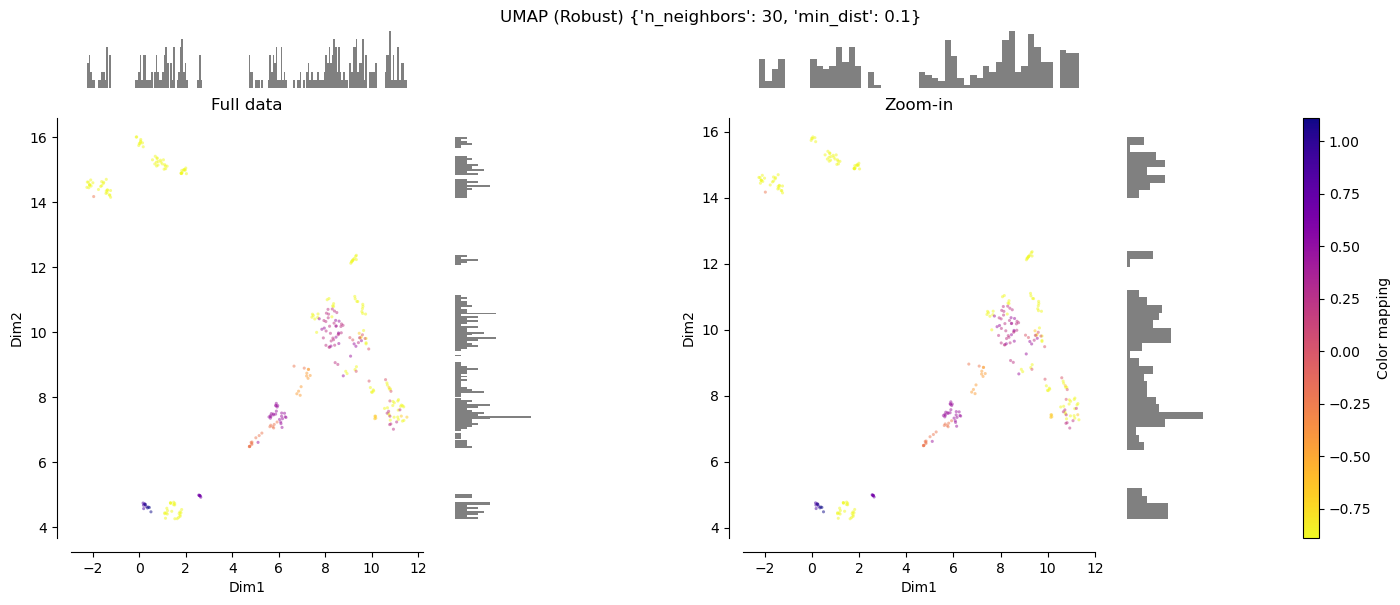

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


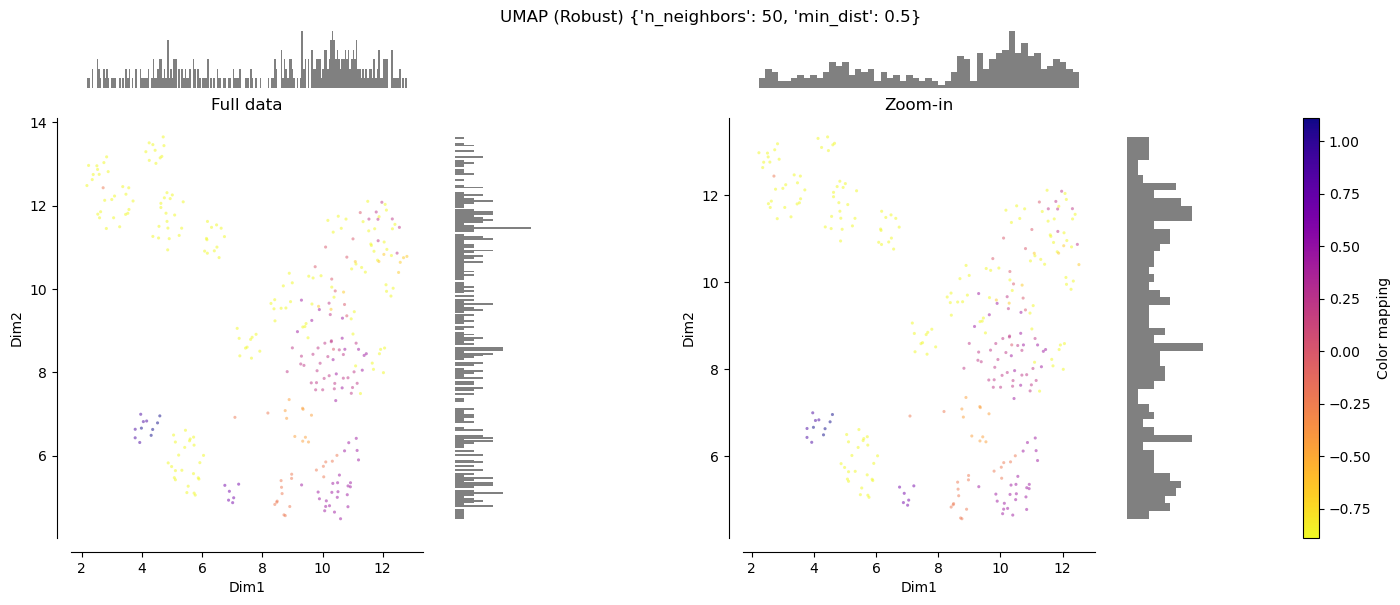

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


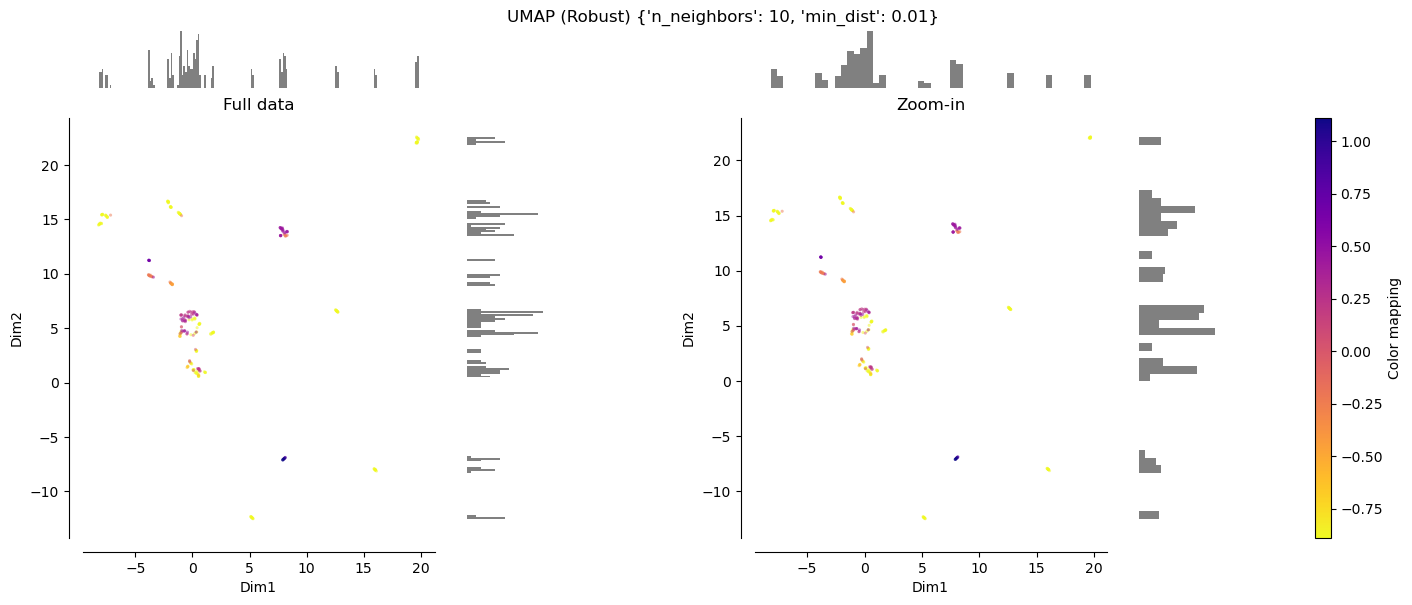

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


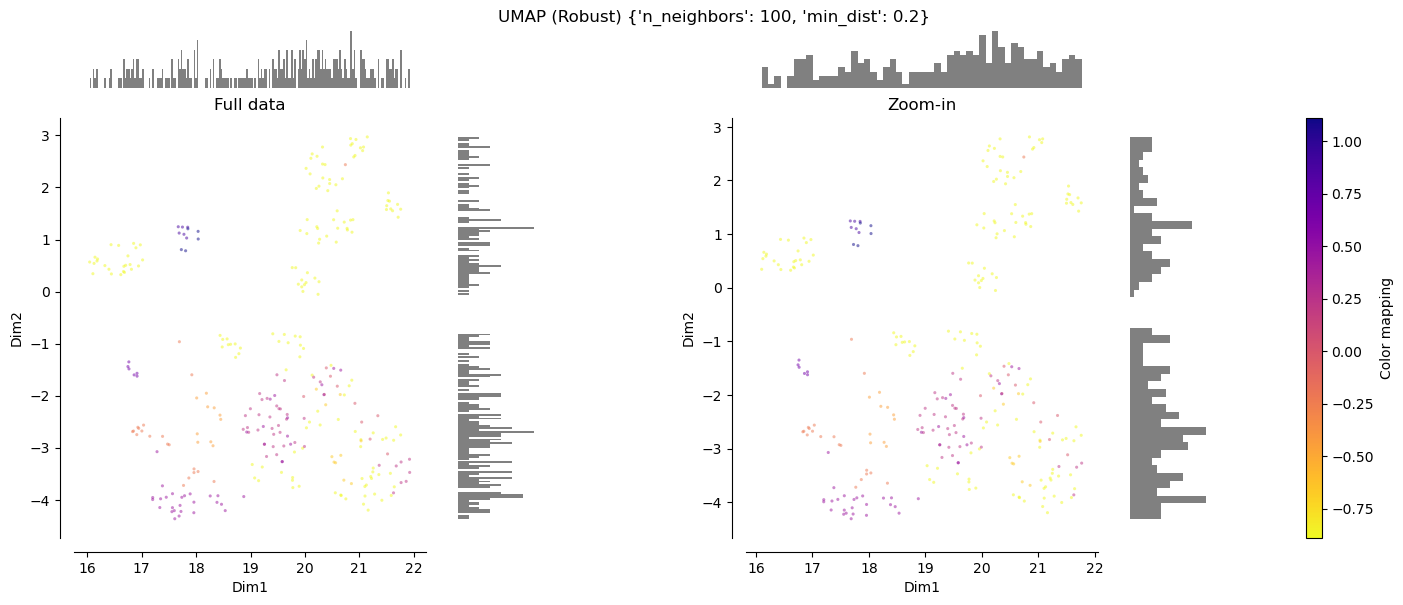

C:\Users\ursus\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


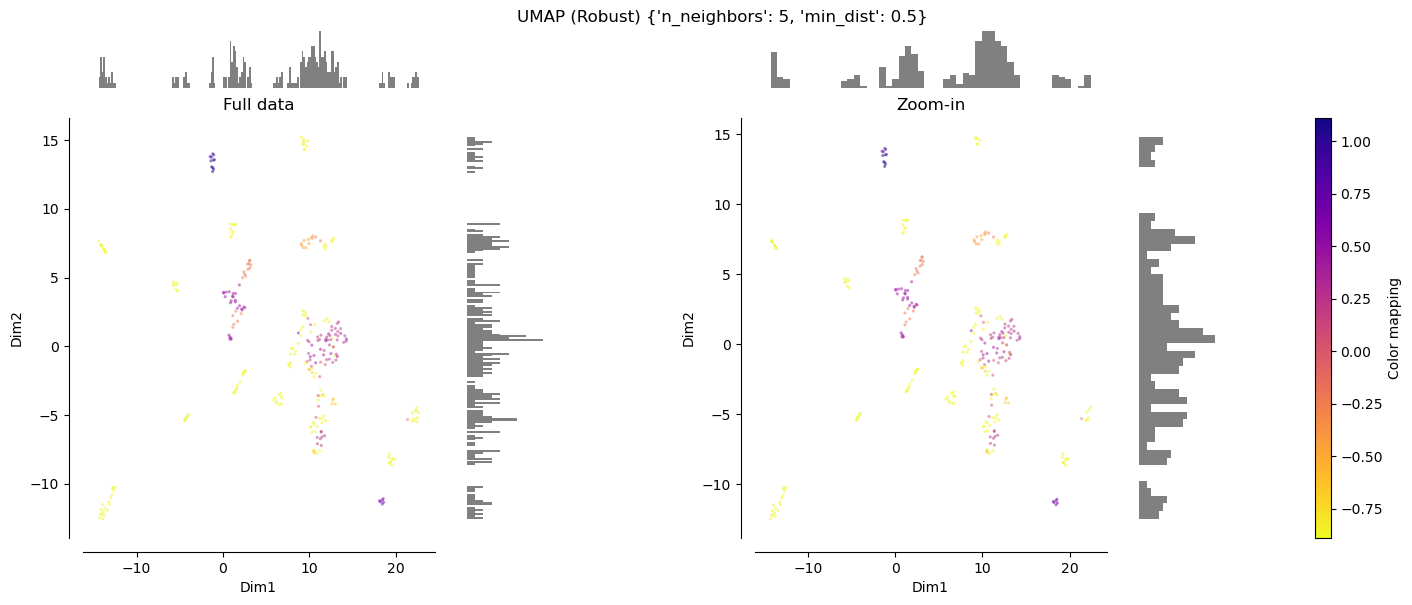

In [22]:
# UMAP
for scale_name in scaled_data.keys():
    X_scaled = scaled_data[scale_name]
    y_color = scaled_colors[scale_name]
    print(f"\n=== Масштабирование: {scale_name} ===")
    for params in umap_params:
        reducer = UMAP(n_components=2, random_state=random, **params)
        emb = reducer.fit_transform(X_scaled)
        make_plot(
            emb, y_color,
            title=f"UMAP ({scale_name}) {params}",
            feature_names=("Dim1", "Dim2")
        )


=== Масштабирование: MinMax ===


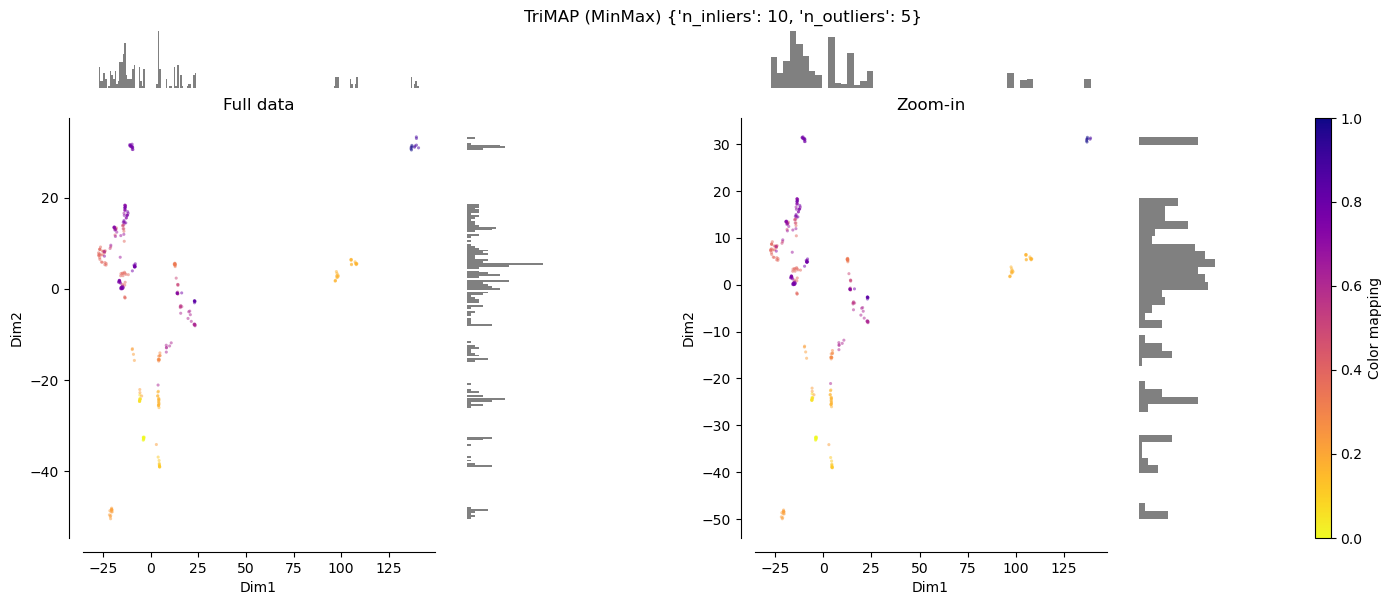

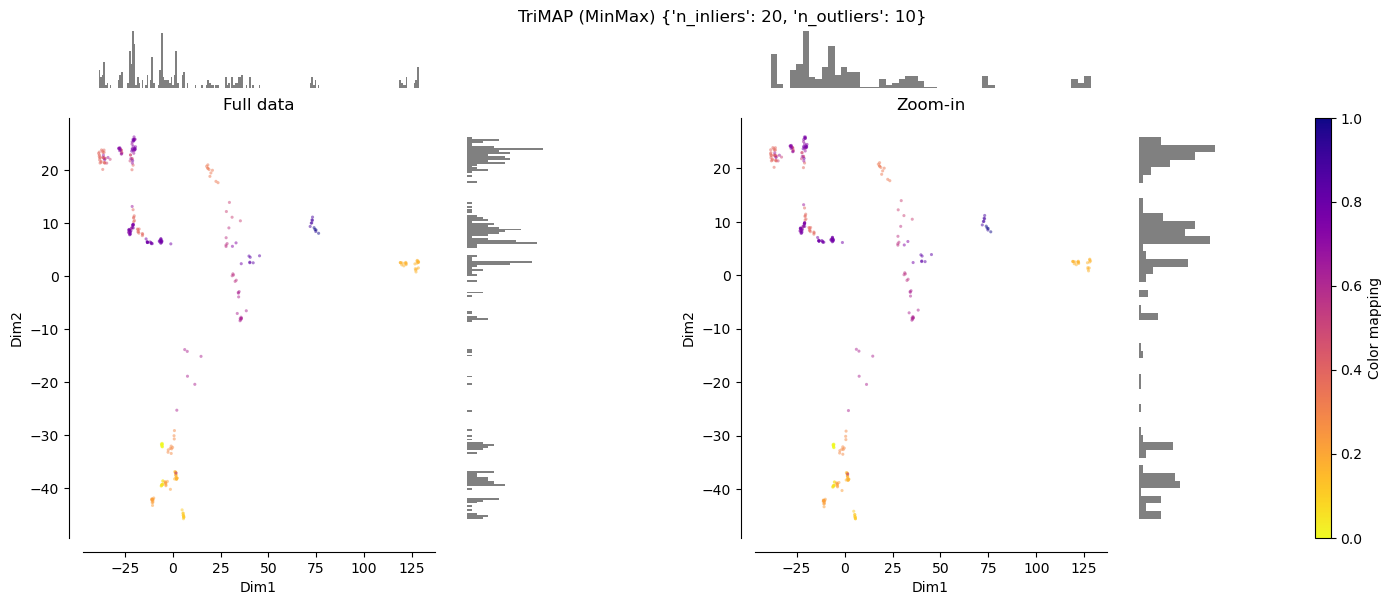

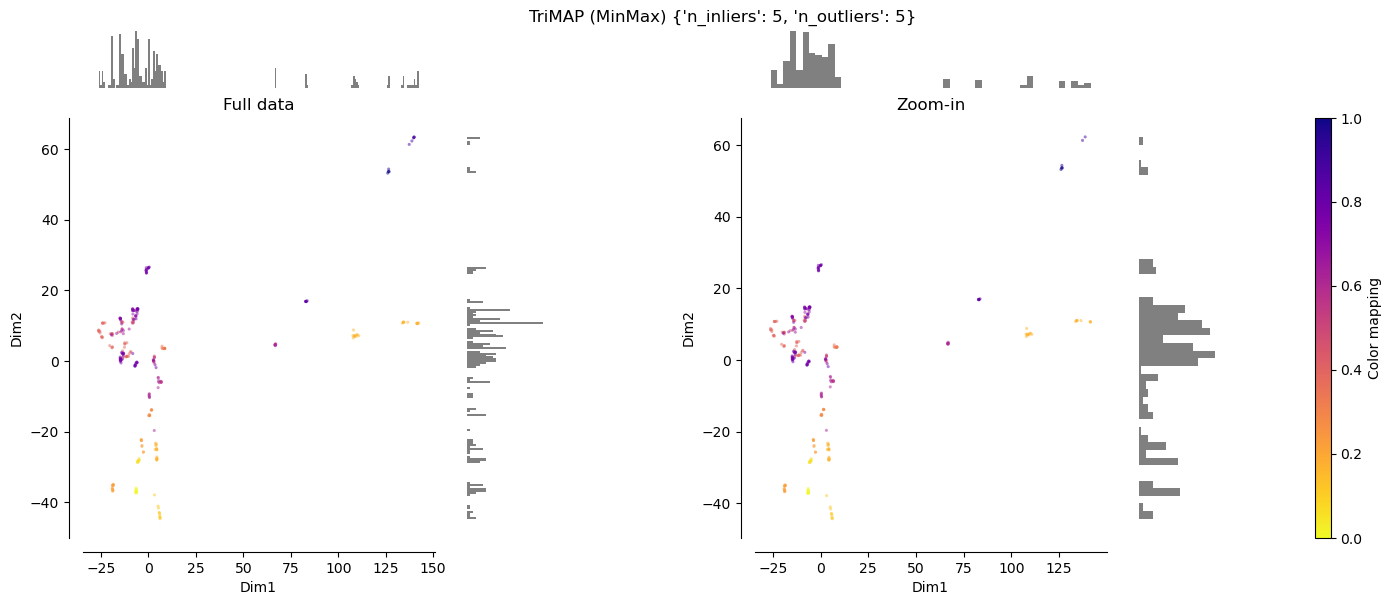

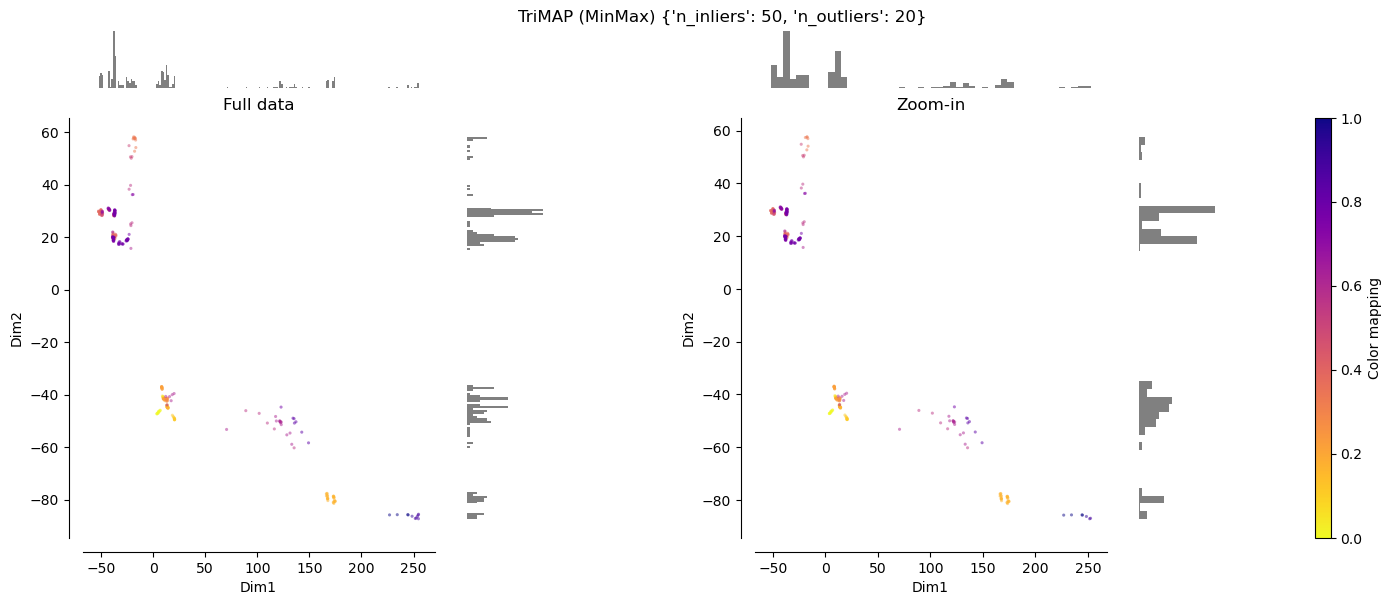

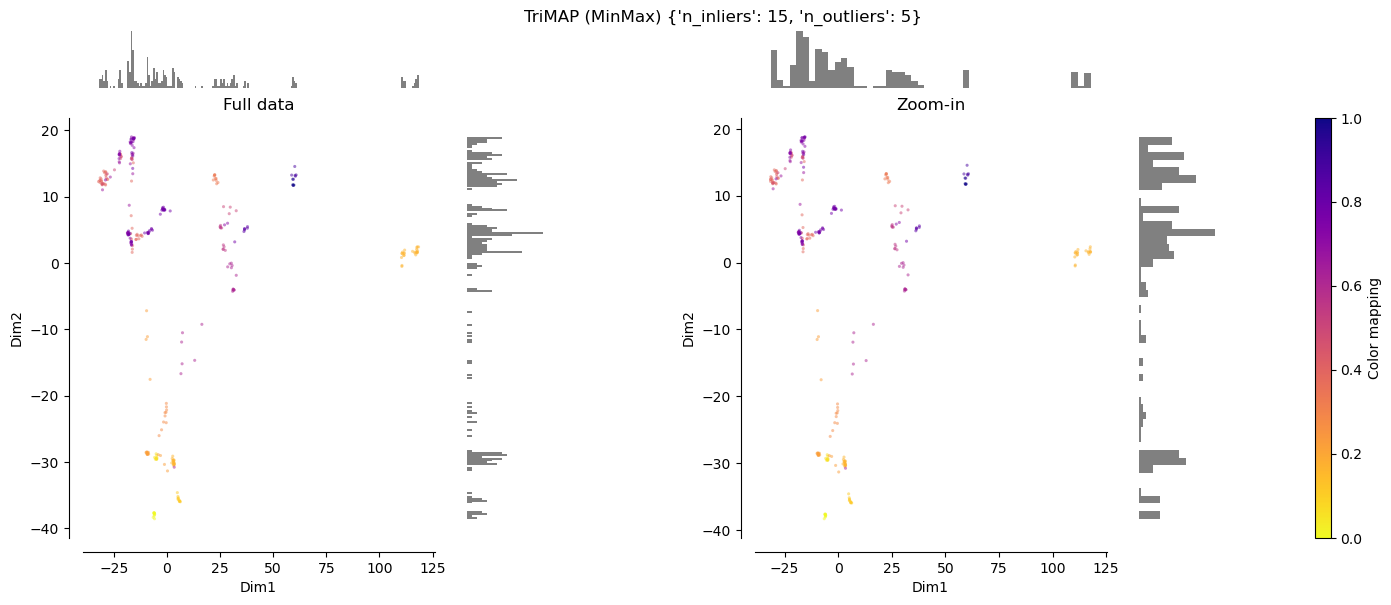

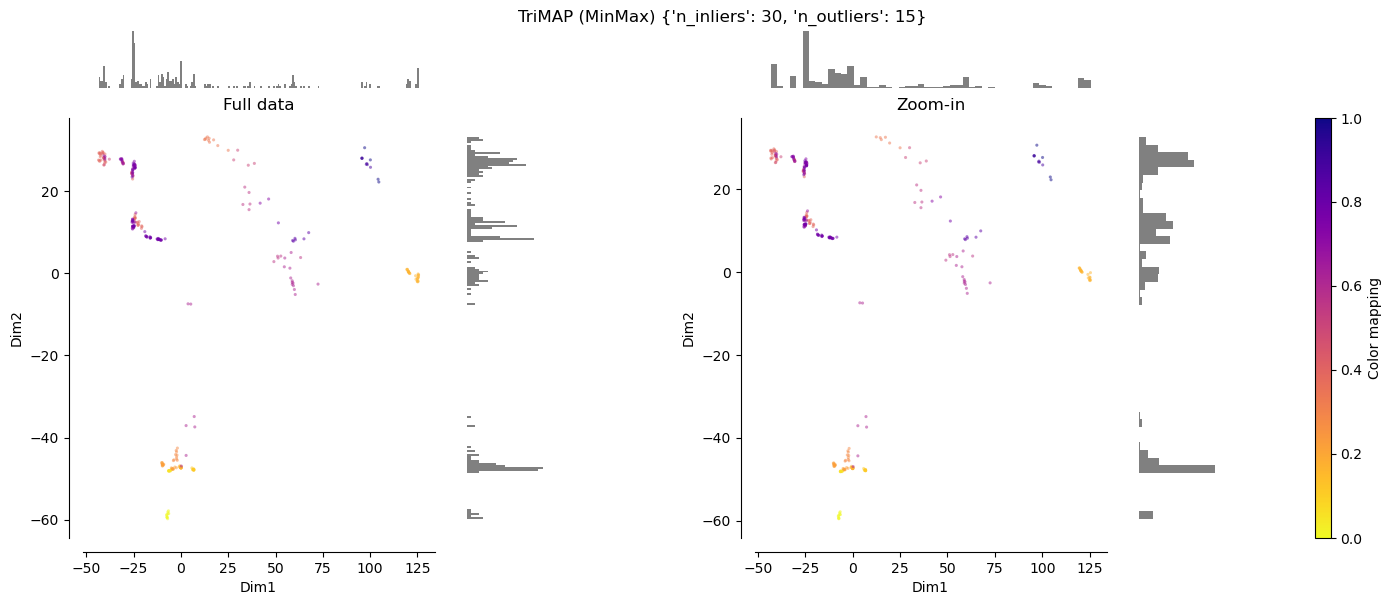


=== Масштабирование: Standard ===


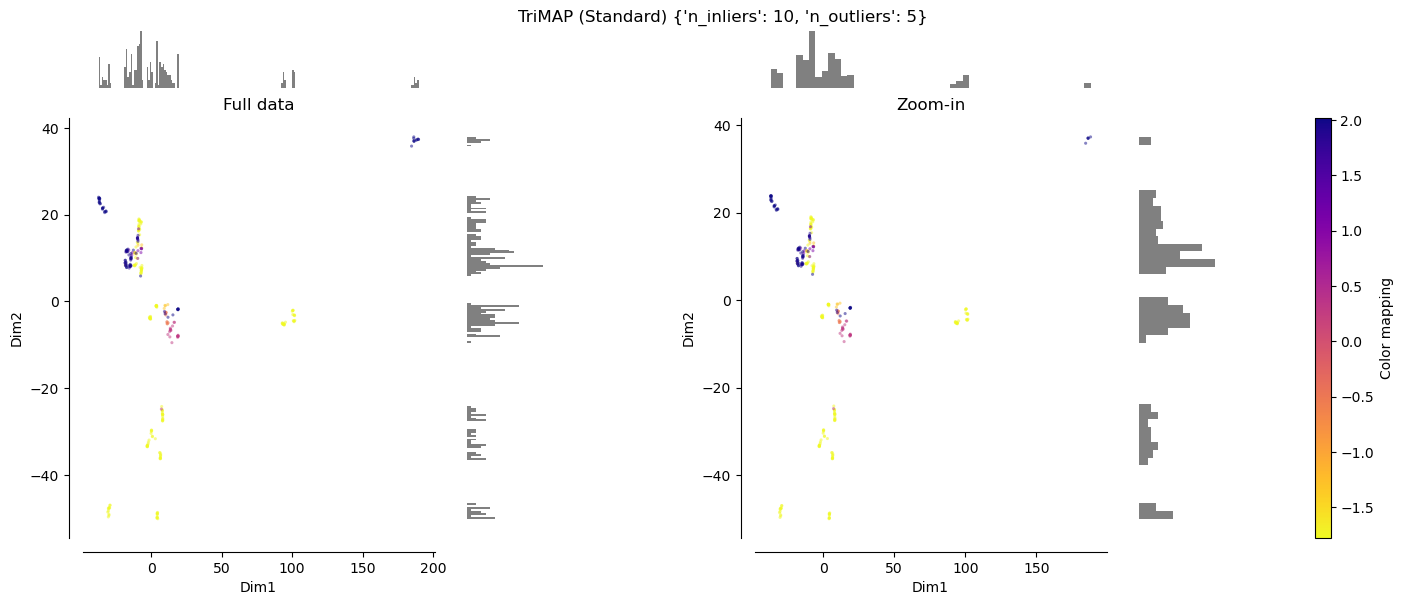

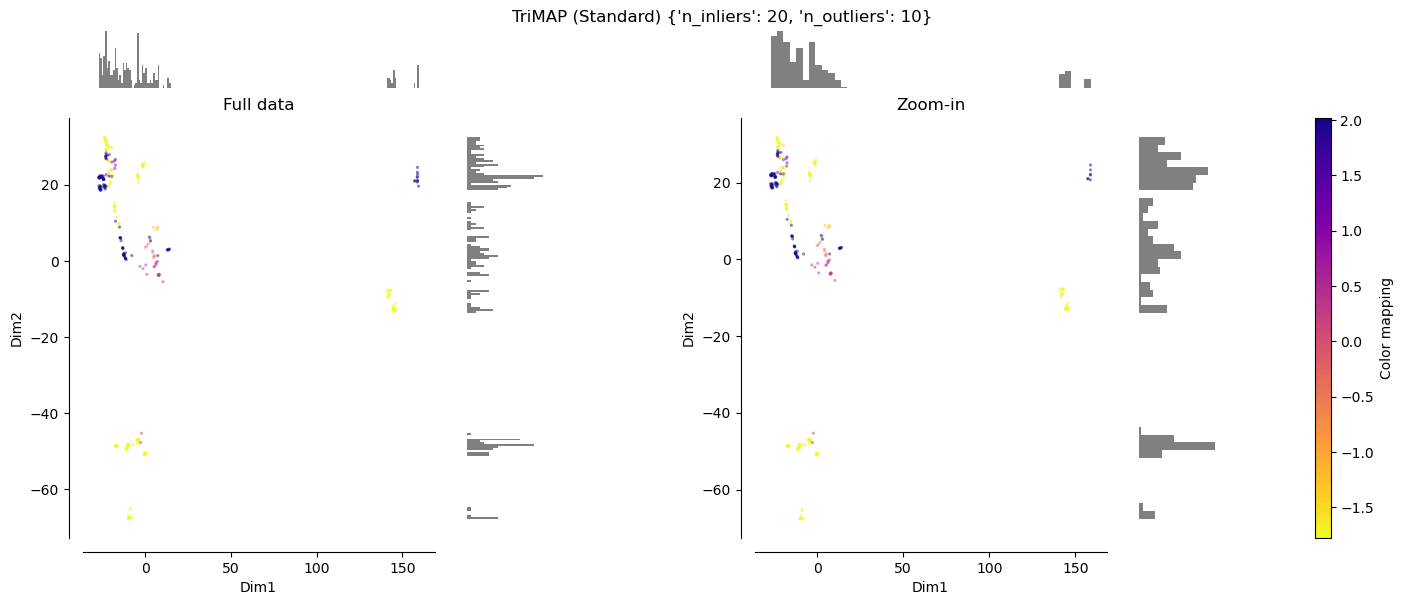

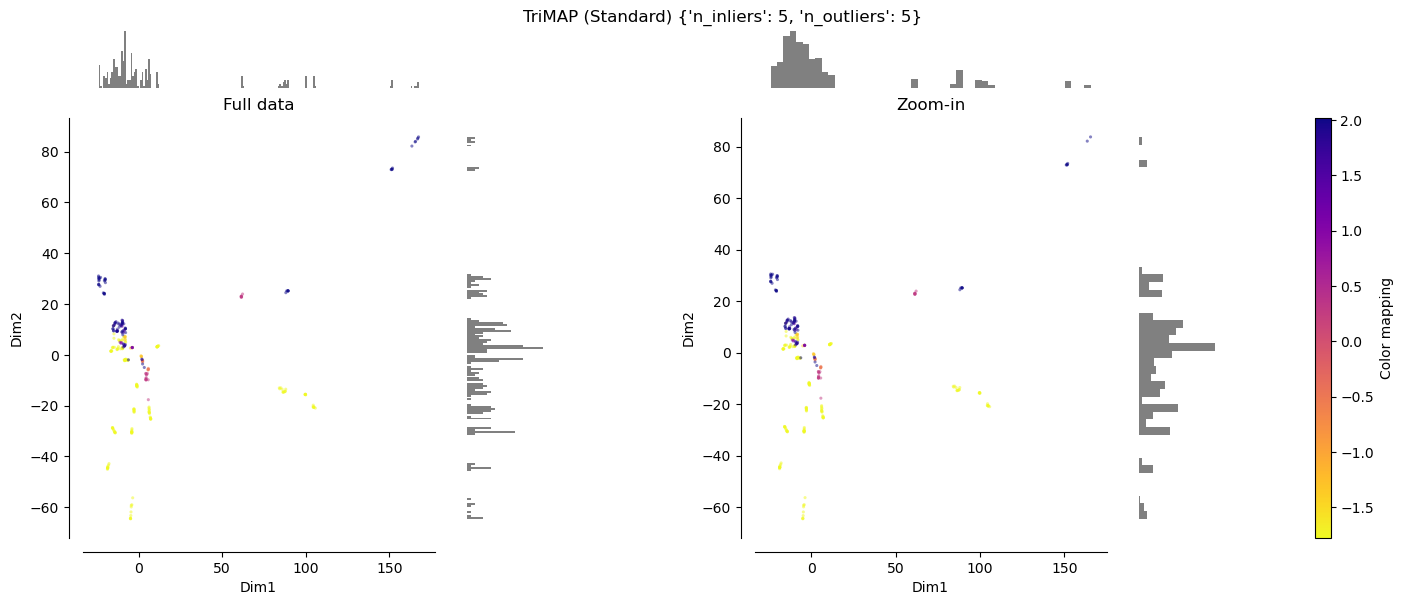

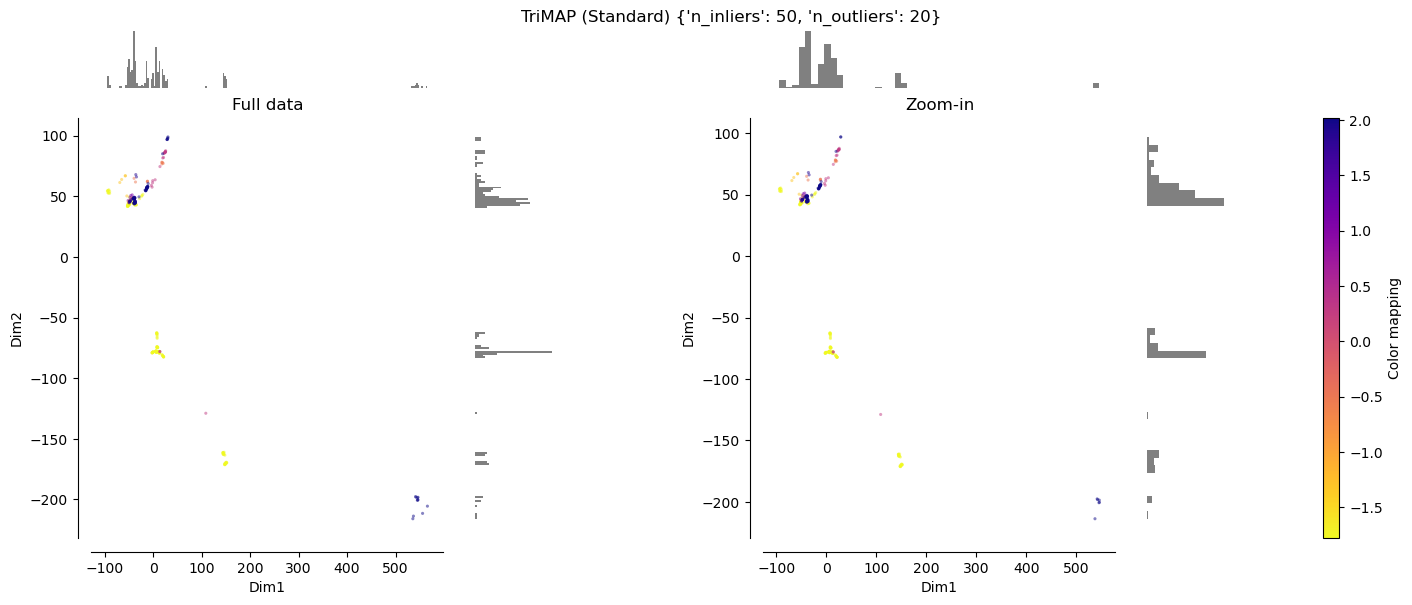

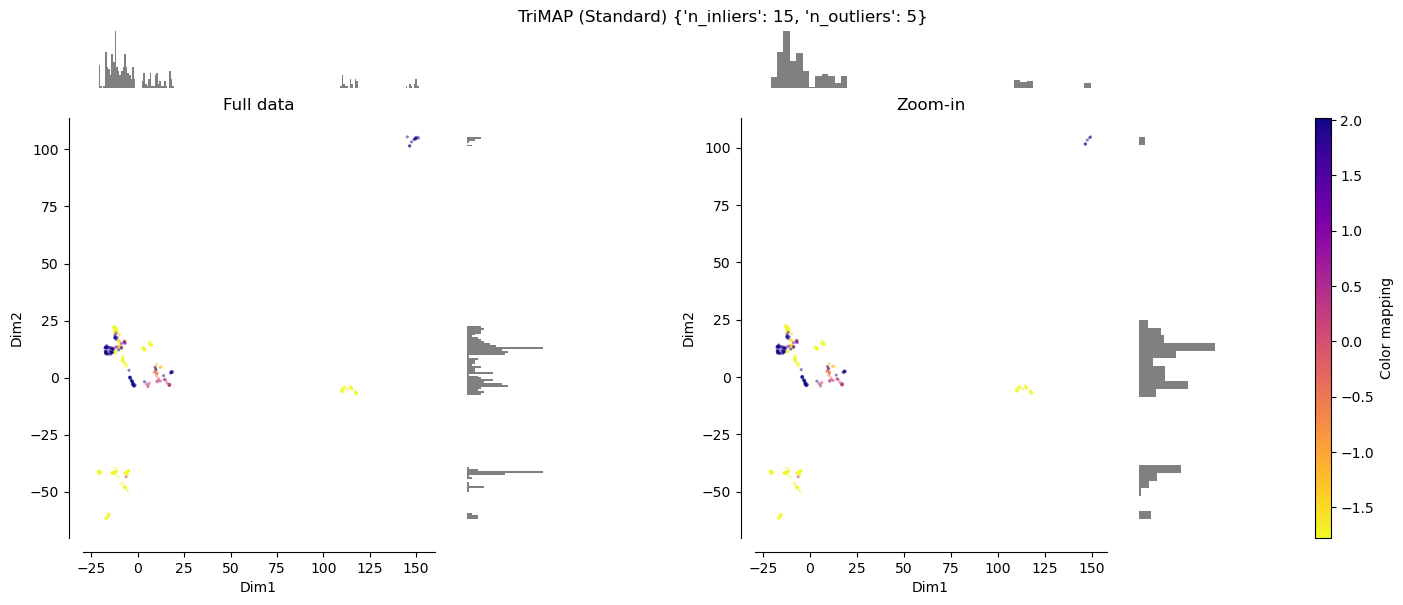

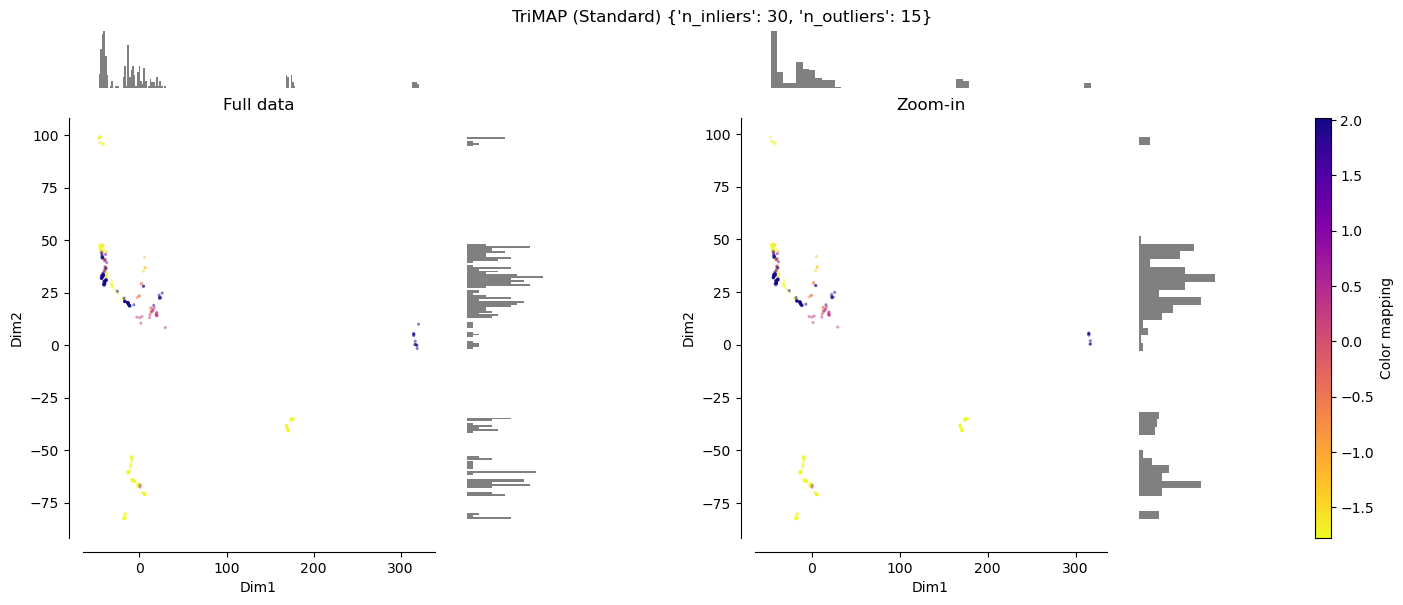


=== Масштабирование: Robust ===


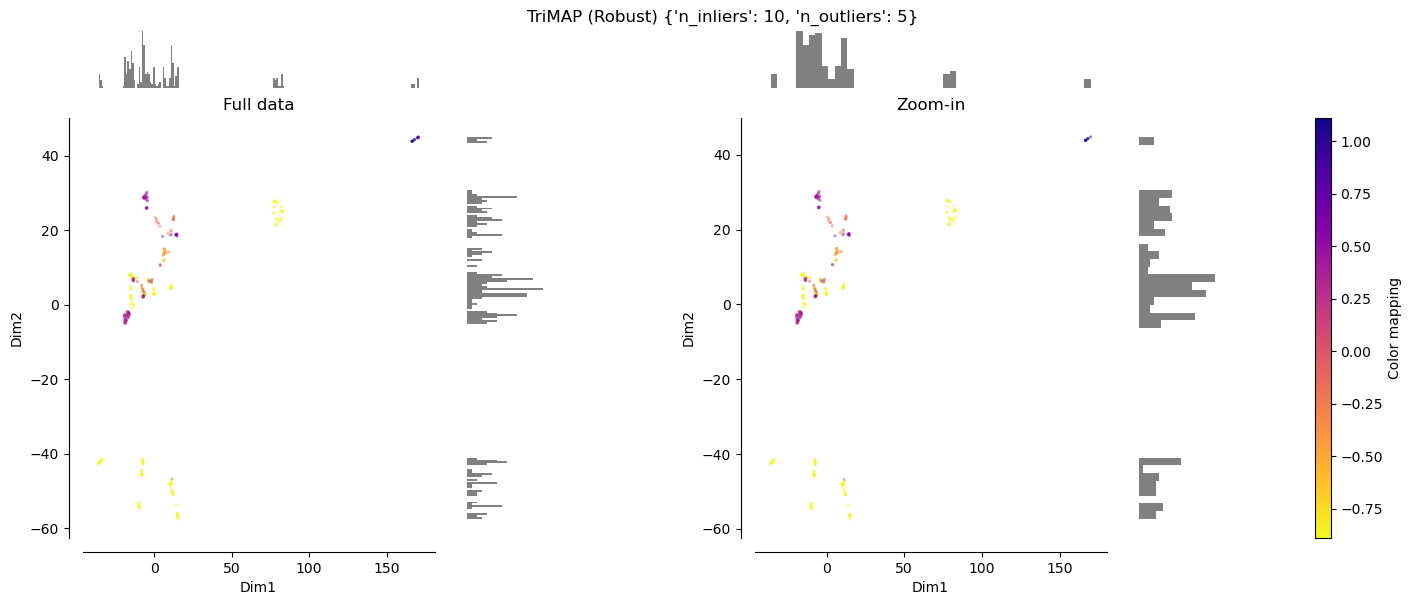

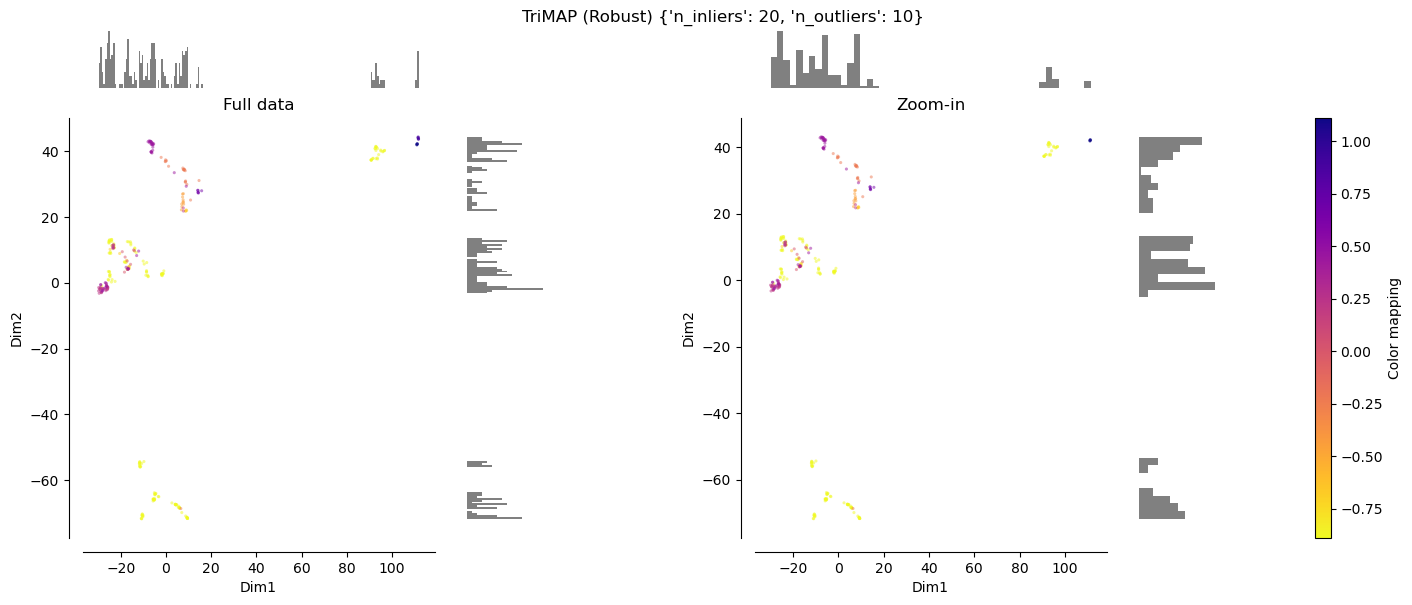

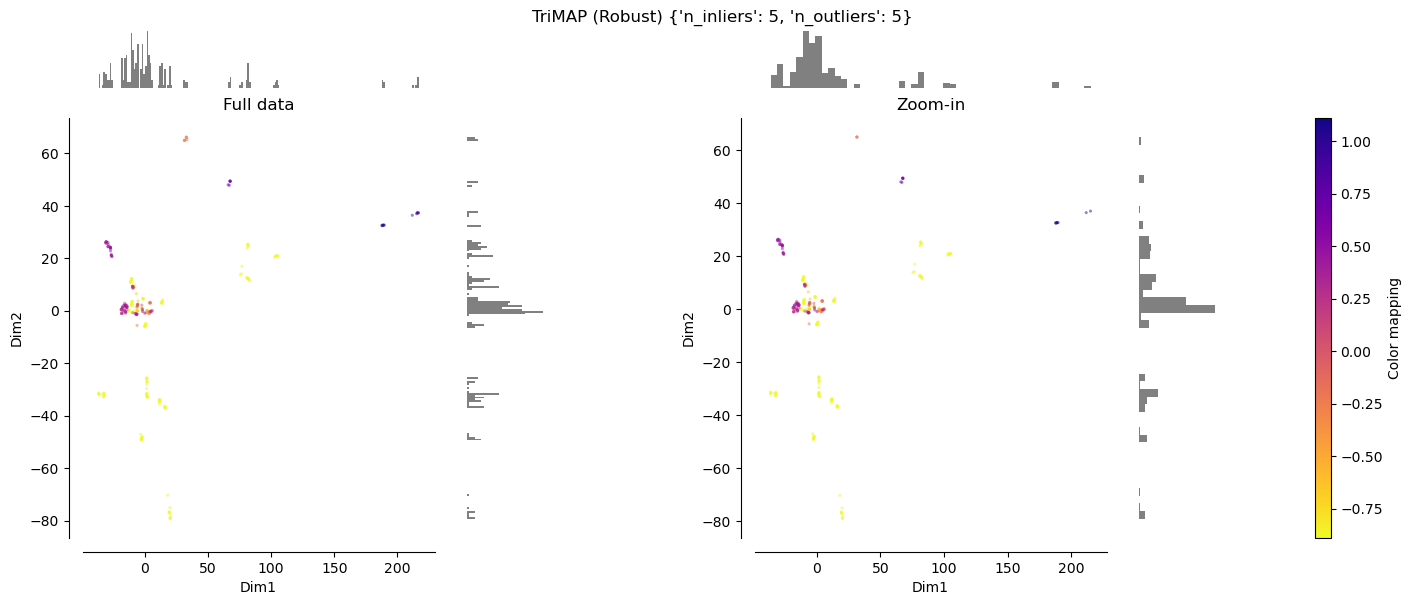

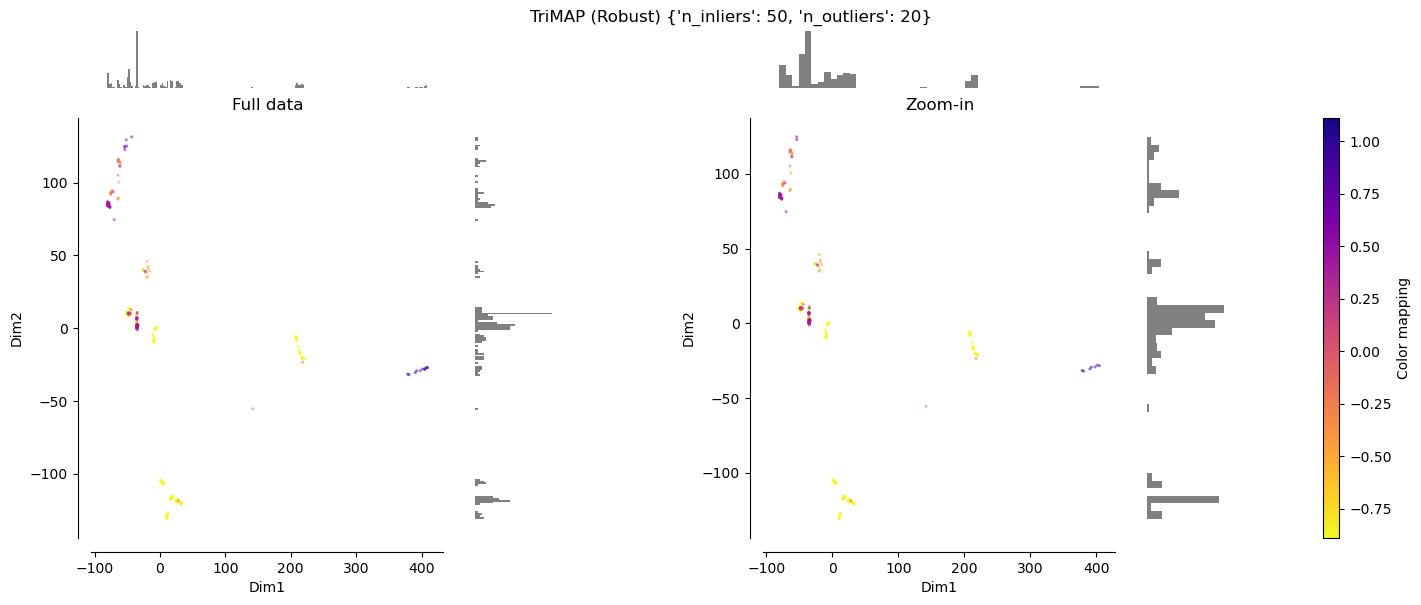

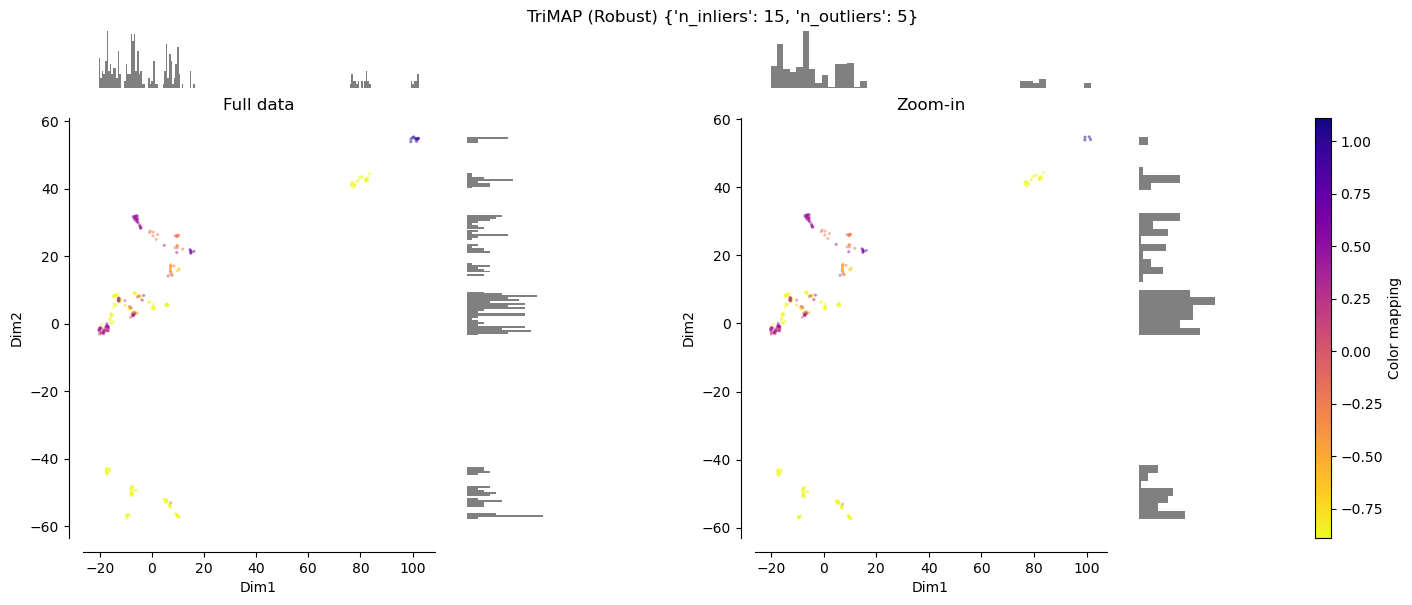

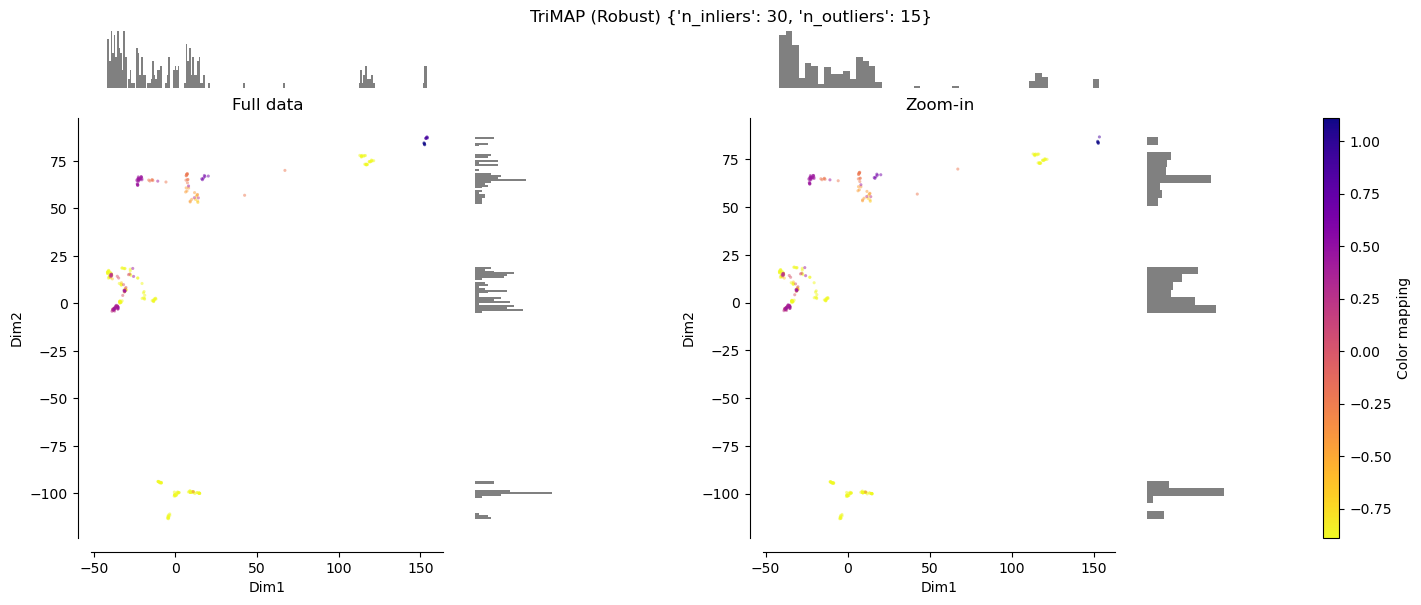

In [23]:
# TriMAP
for scale_name in scaled_data.keys():
    X_scaled = scaled_data[scale_name]
    y_color = scaled_colors[scale_name]
    print(f"\n=== Масштабирование: {scale_name} ===")
    for params in trimap_params:
        reducer = trimap.TRIMAP(n_dims=2, n_random=random, **params)
        emb = reducer.fit_transform(X_scaled)
        make_plot(
            emb, y_color,
            title=f"TriMAP ({scale_name}) {params}",
            feature_names=("Dim1", "Dim2")
        )


=== Масштабирование: MinMax ===


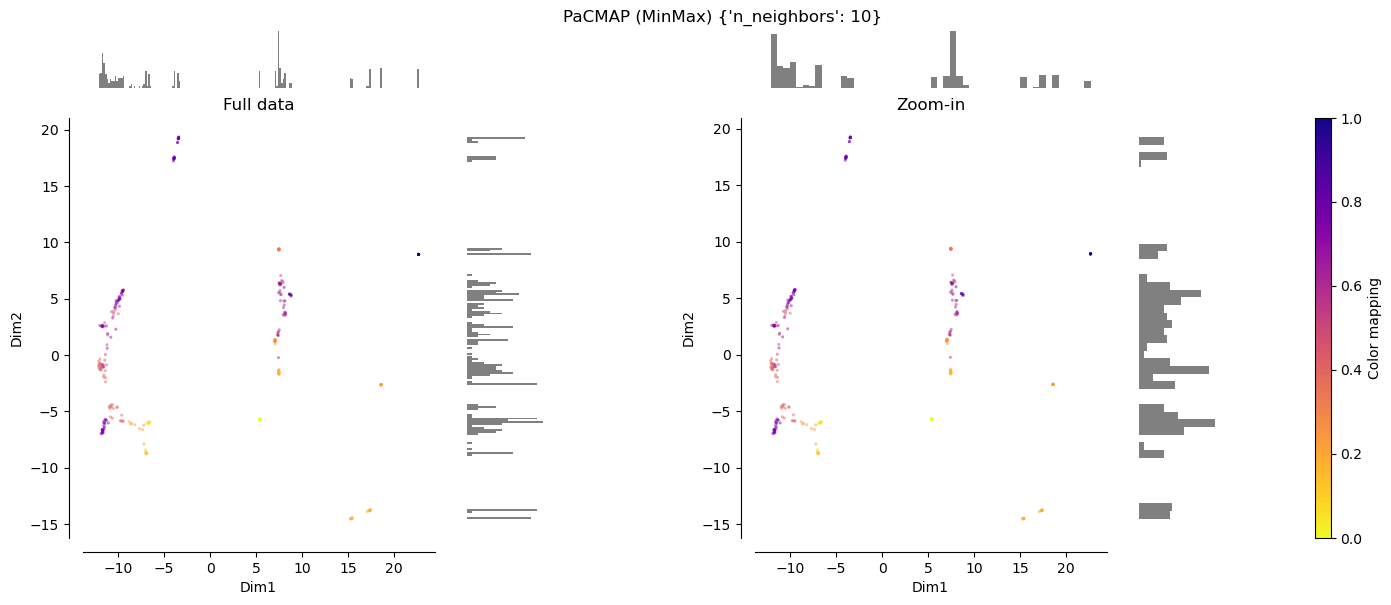

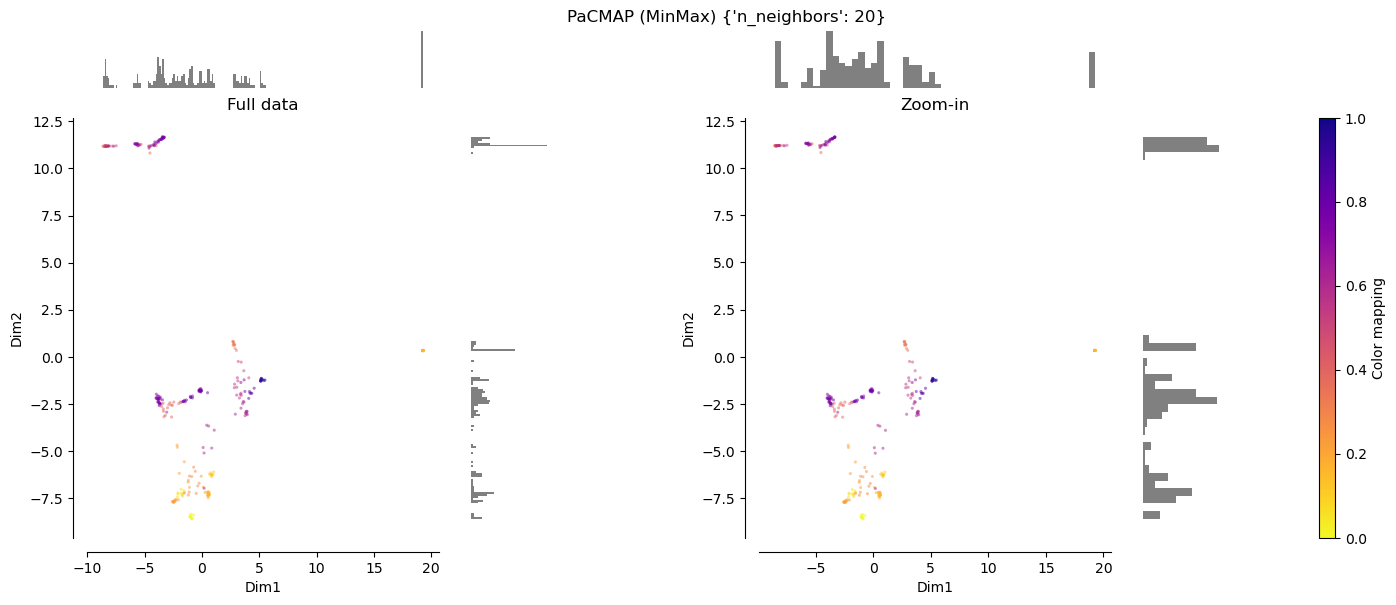

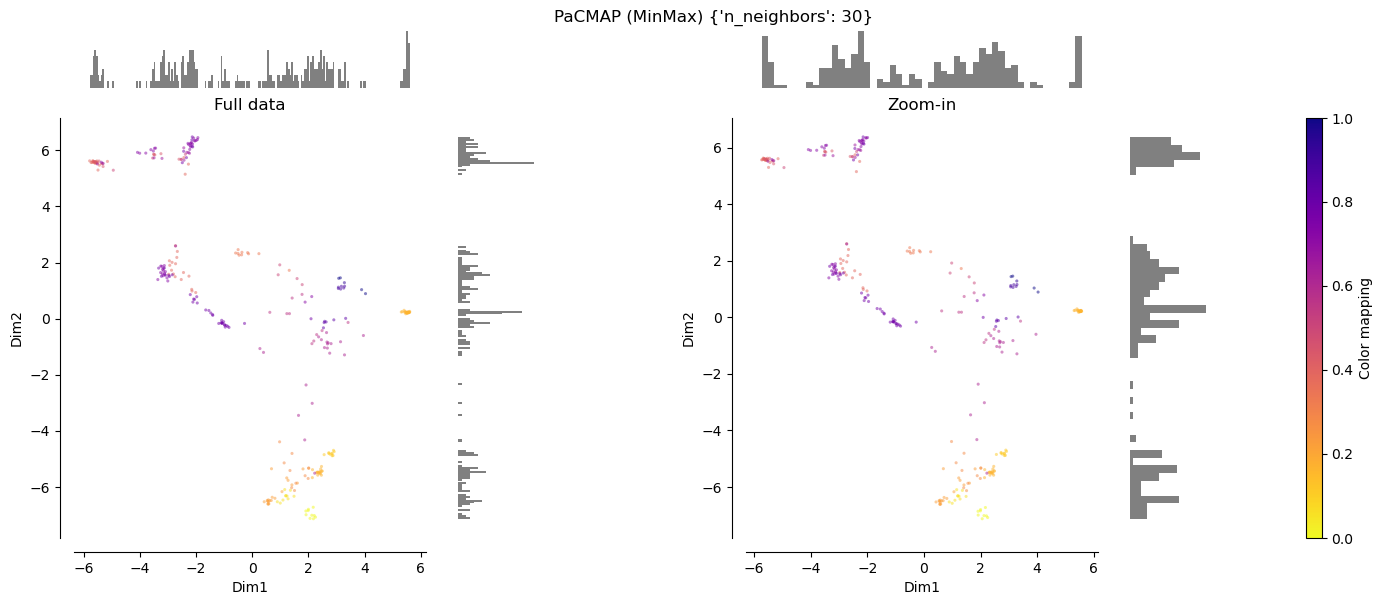

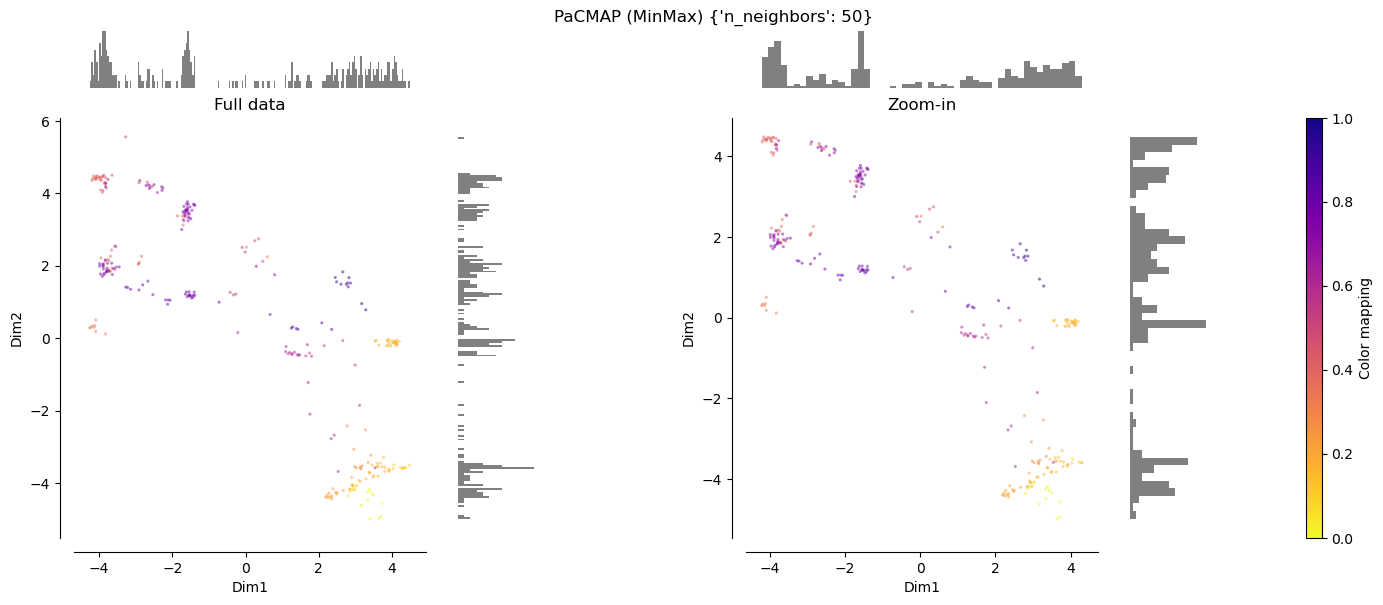

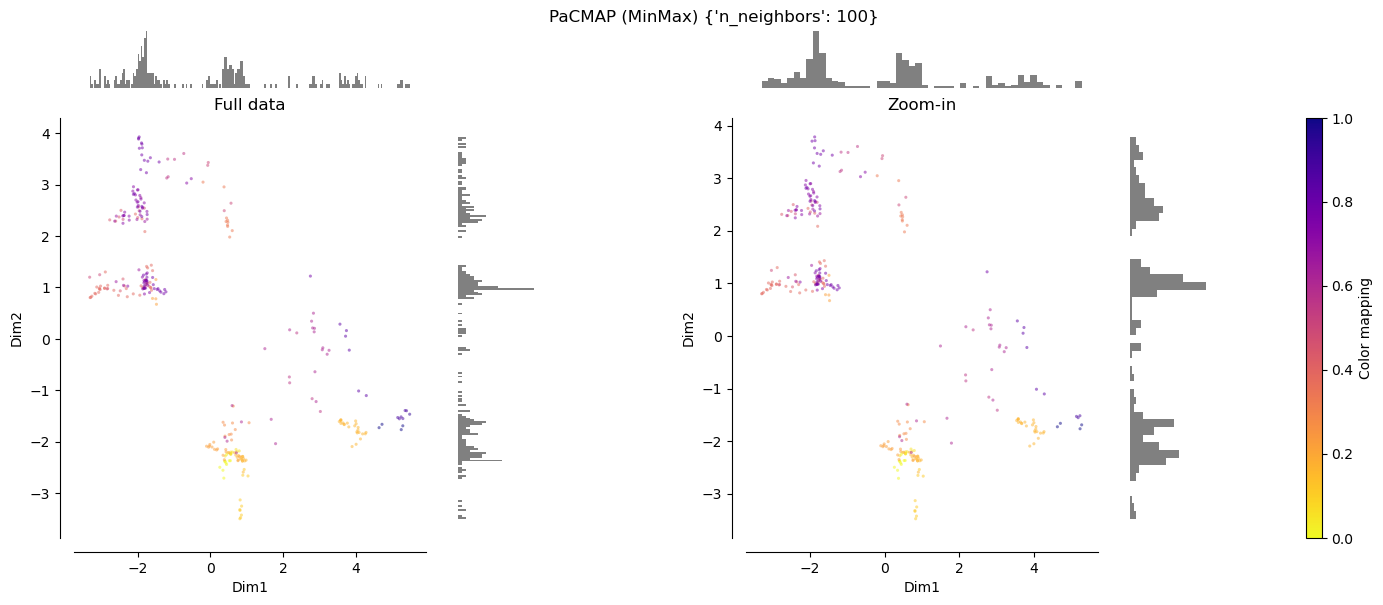

Sample size cannot accommodate number of further pairs requested. n_FP will be reduced.


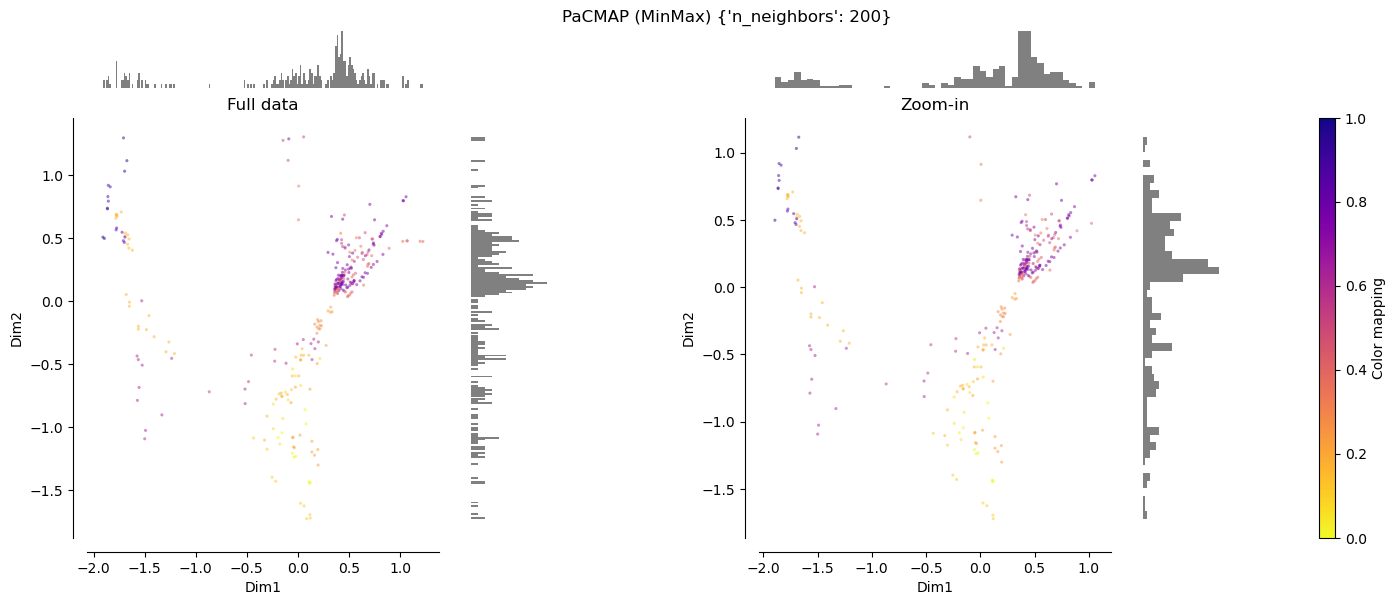


=== Масштабирование: Standard ===


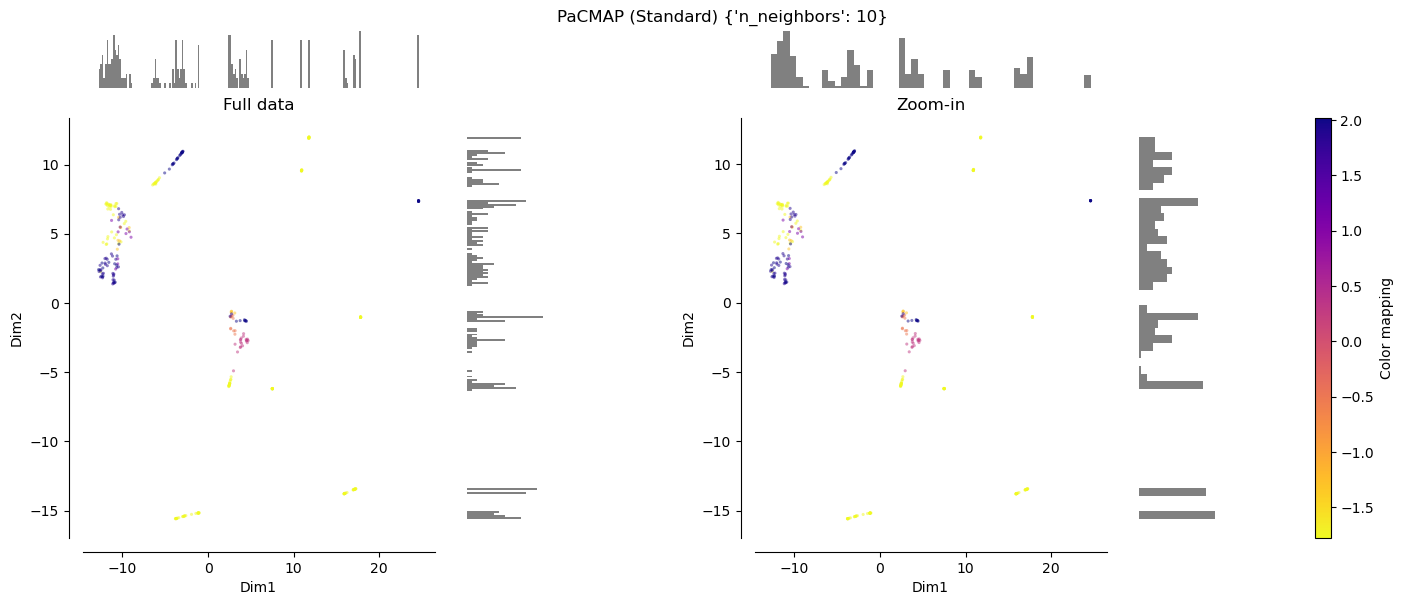

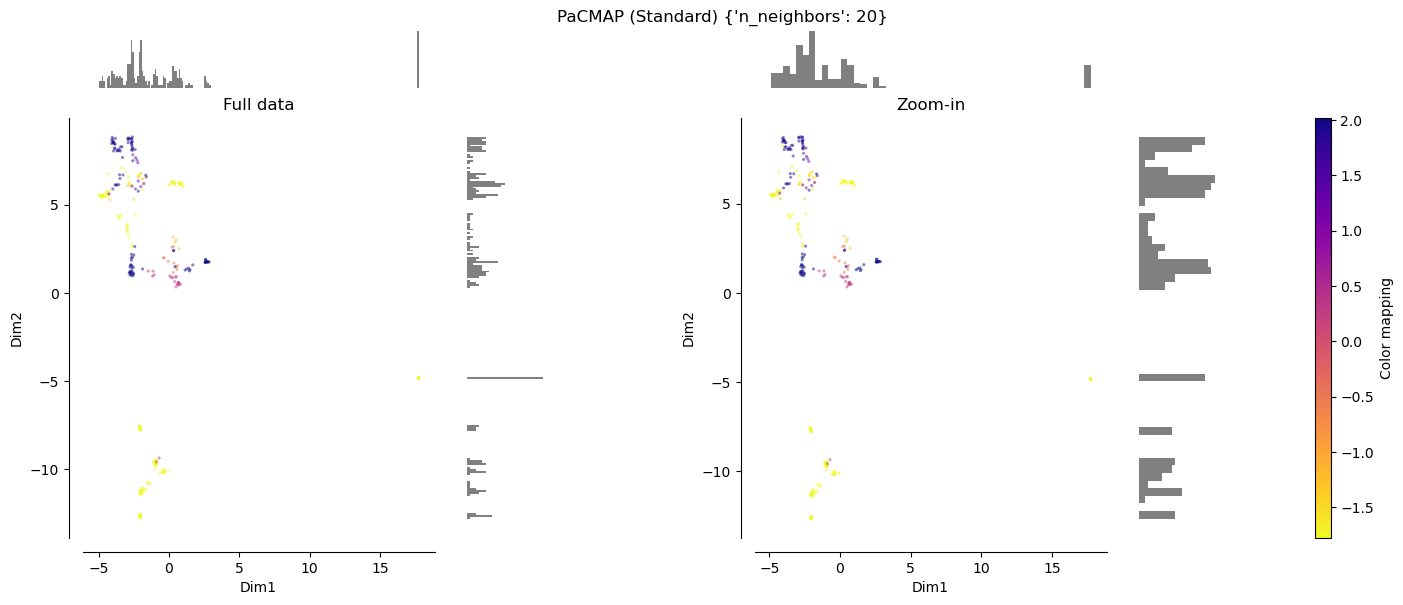

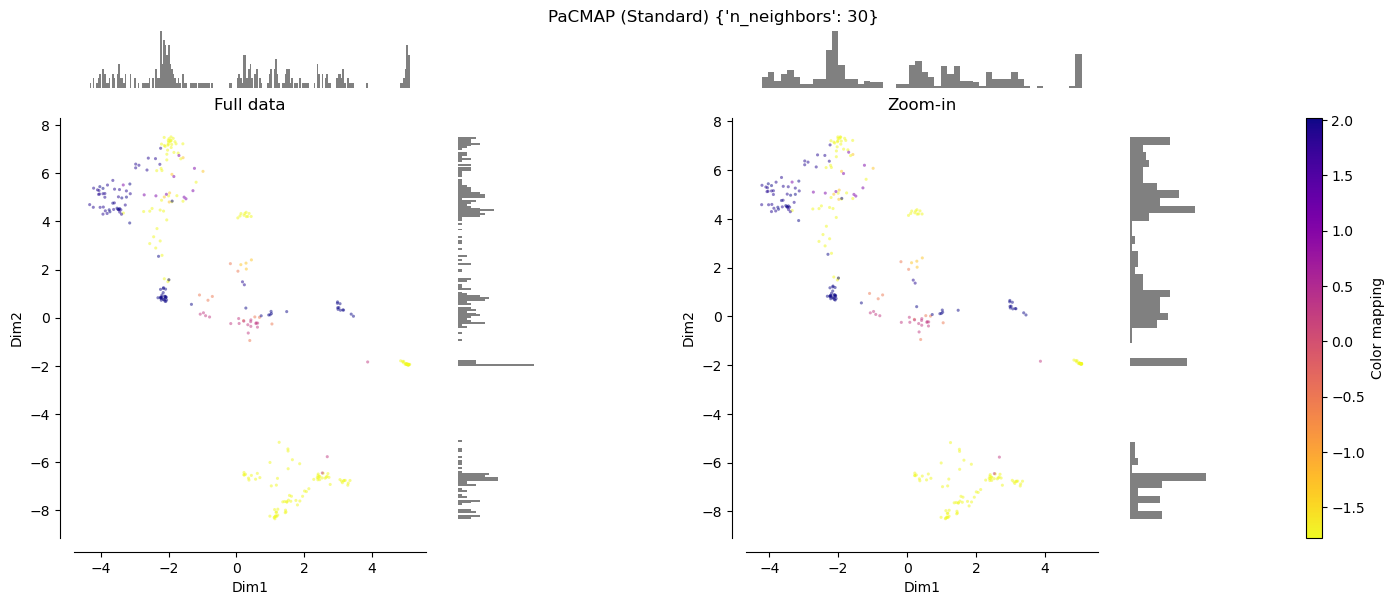

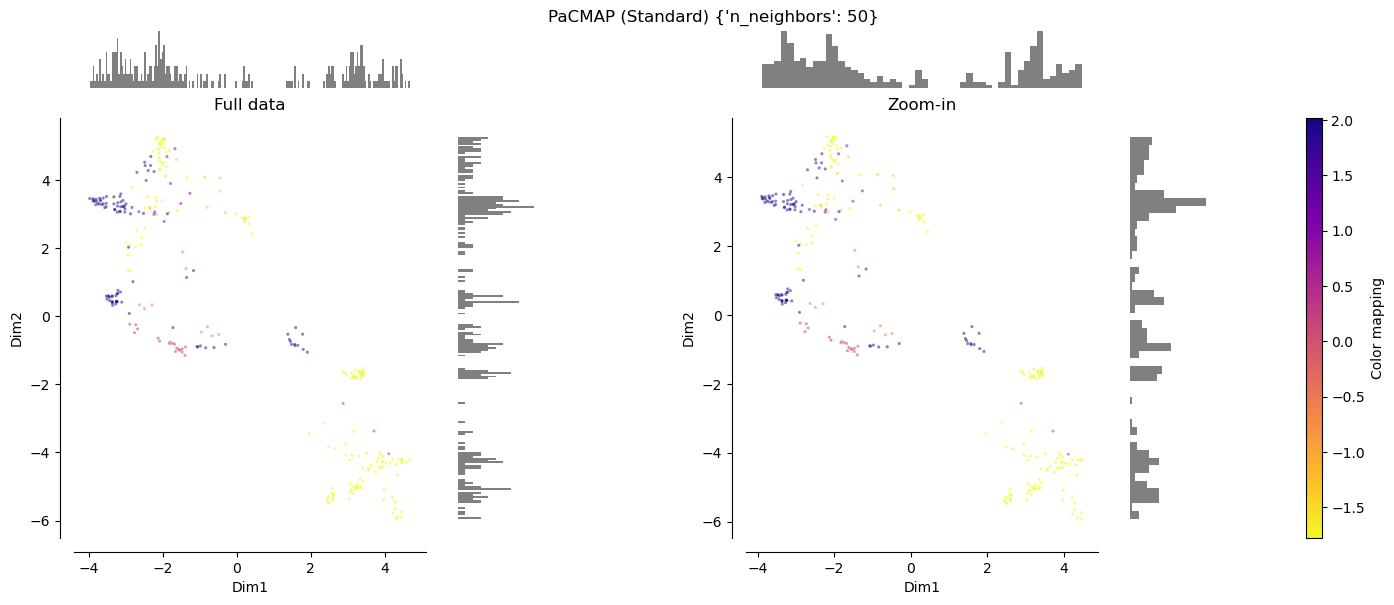

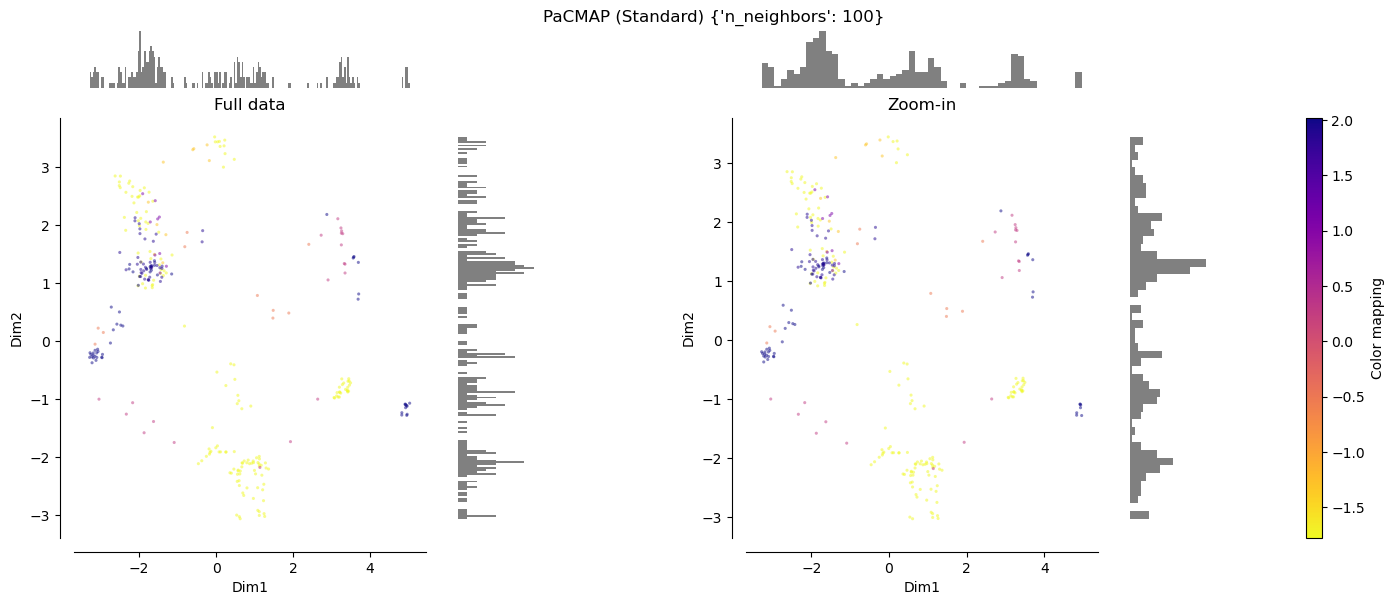

Sample size cannot accommodate number of further pairs requested. n_FP will be reduced.


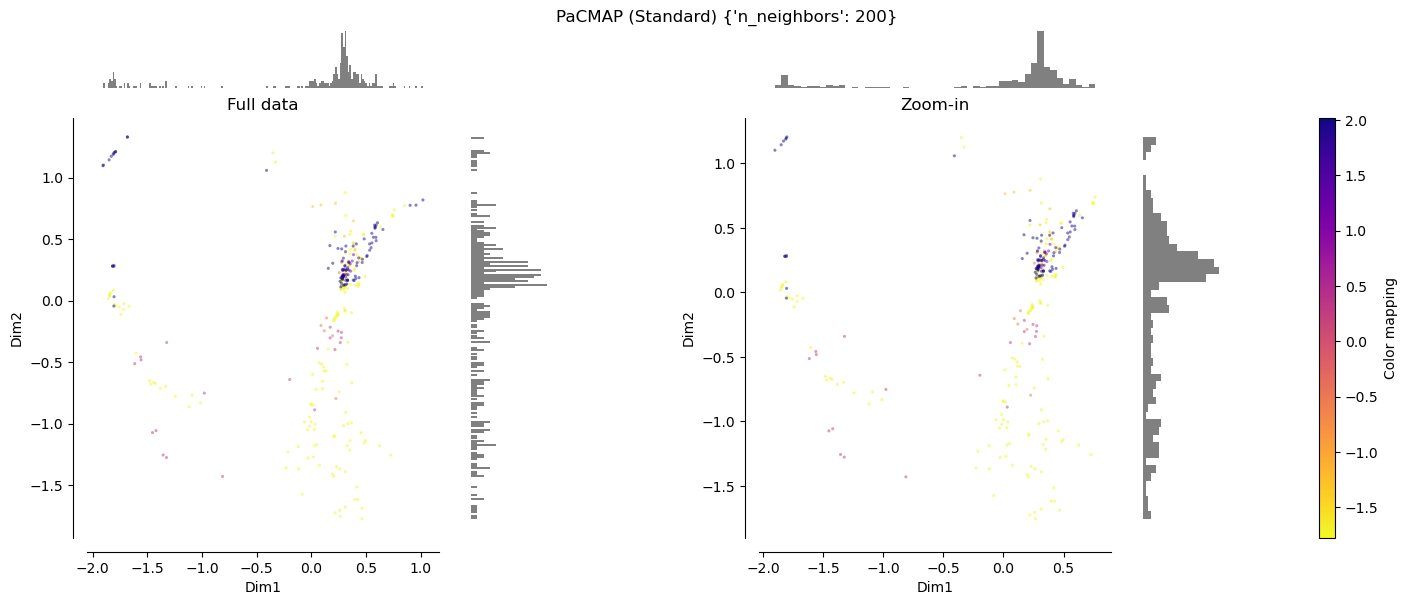


=== Масштабирование: Robust ===


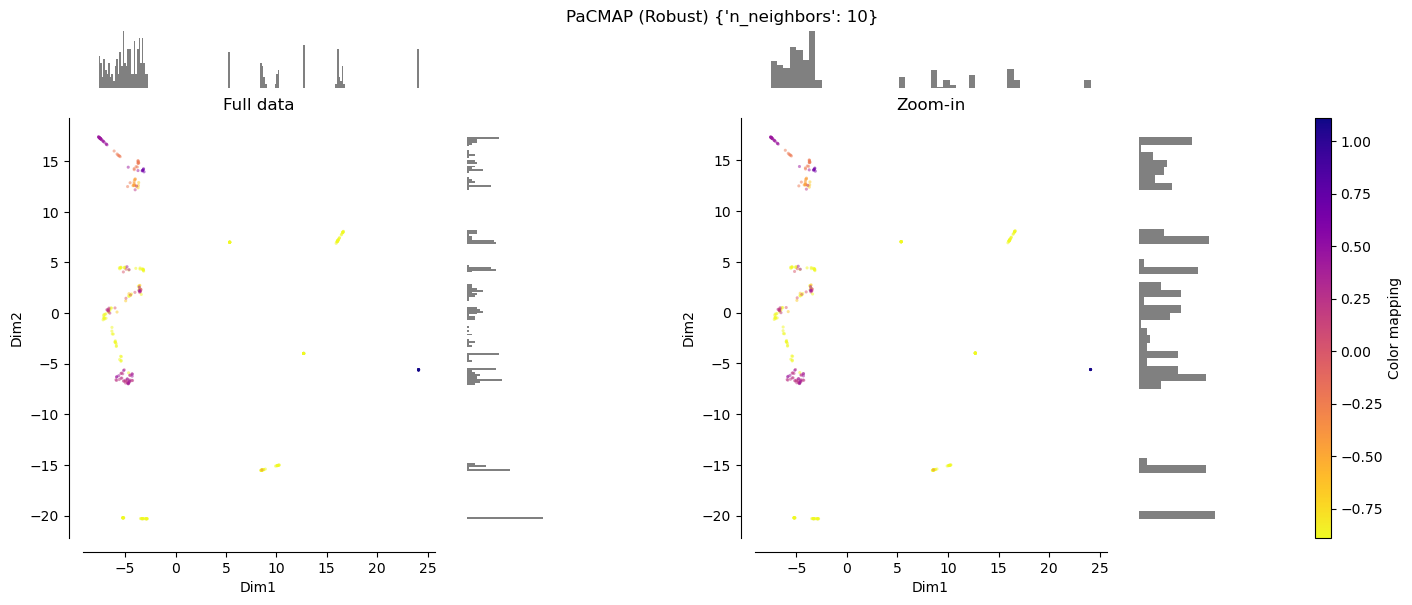

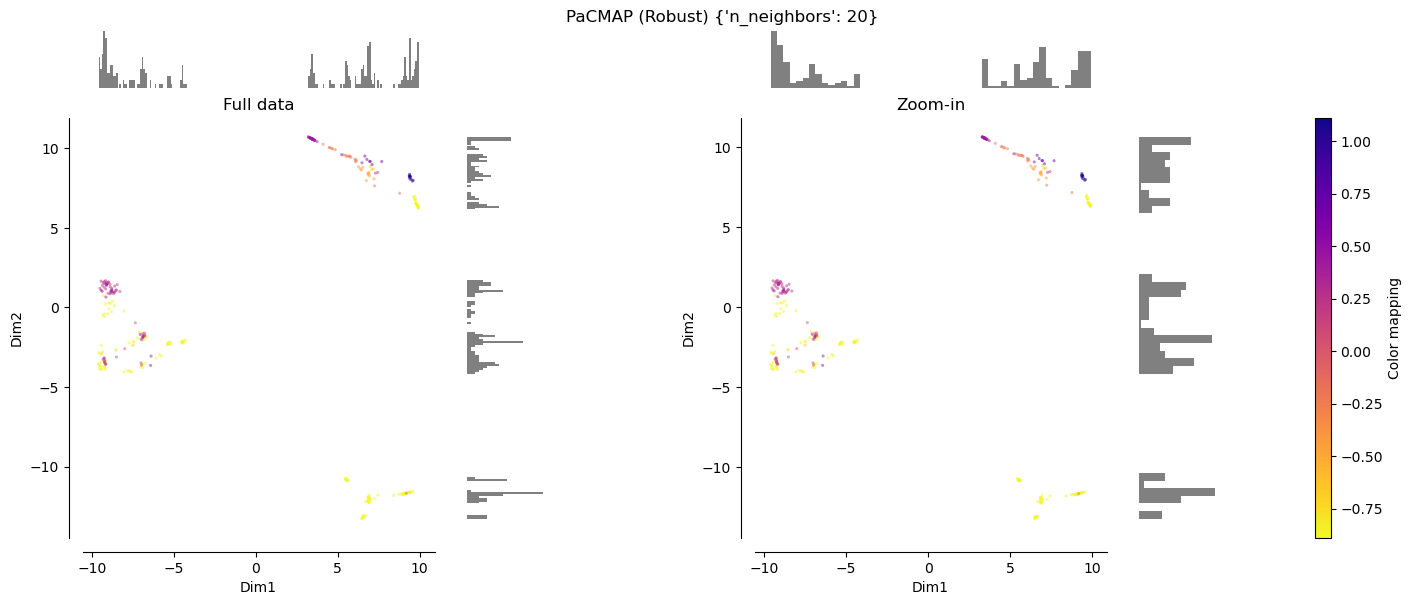

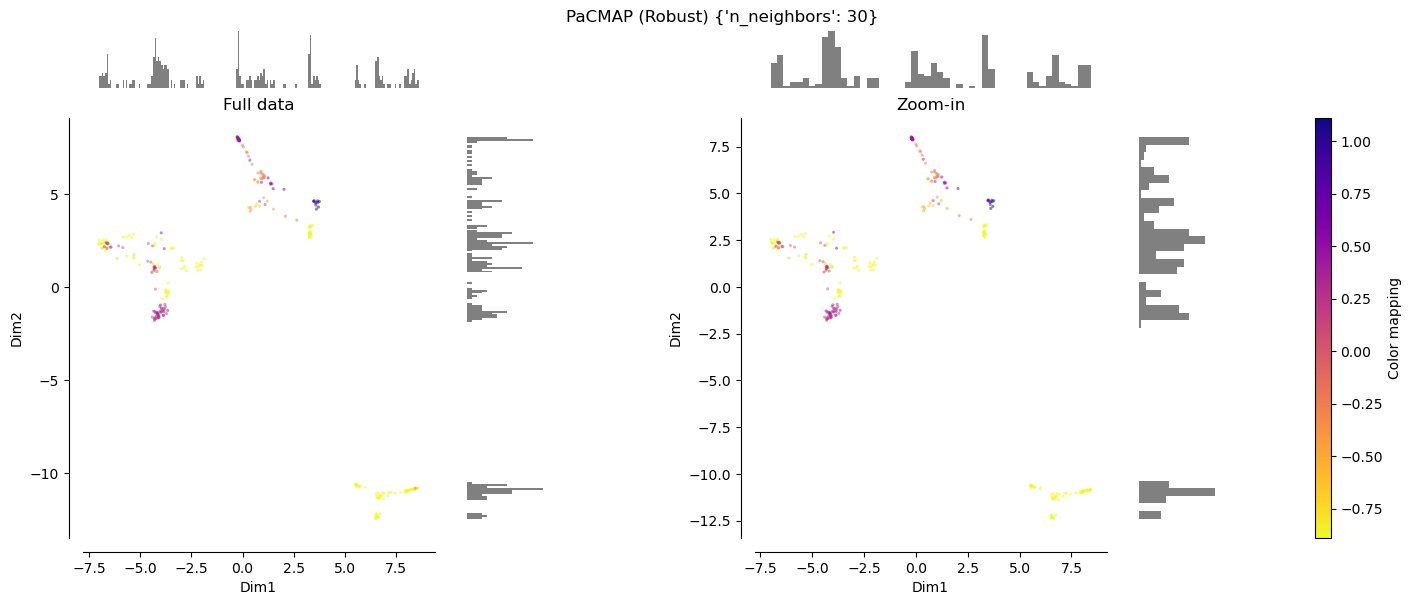

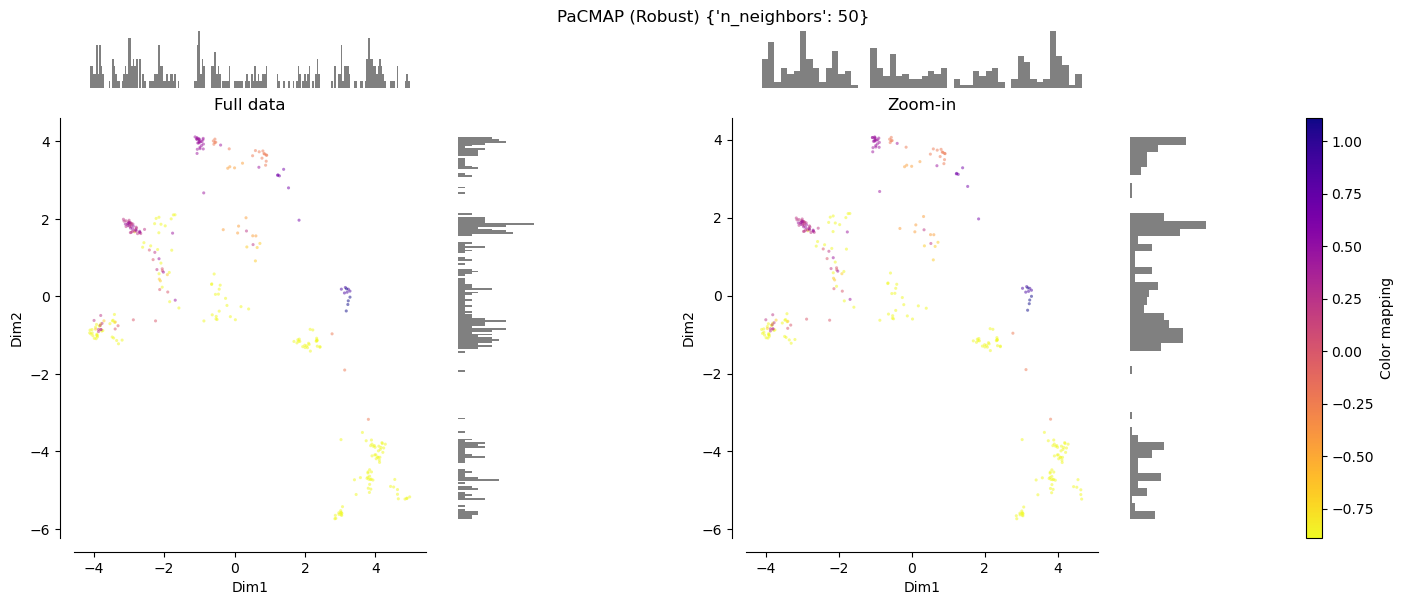

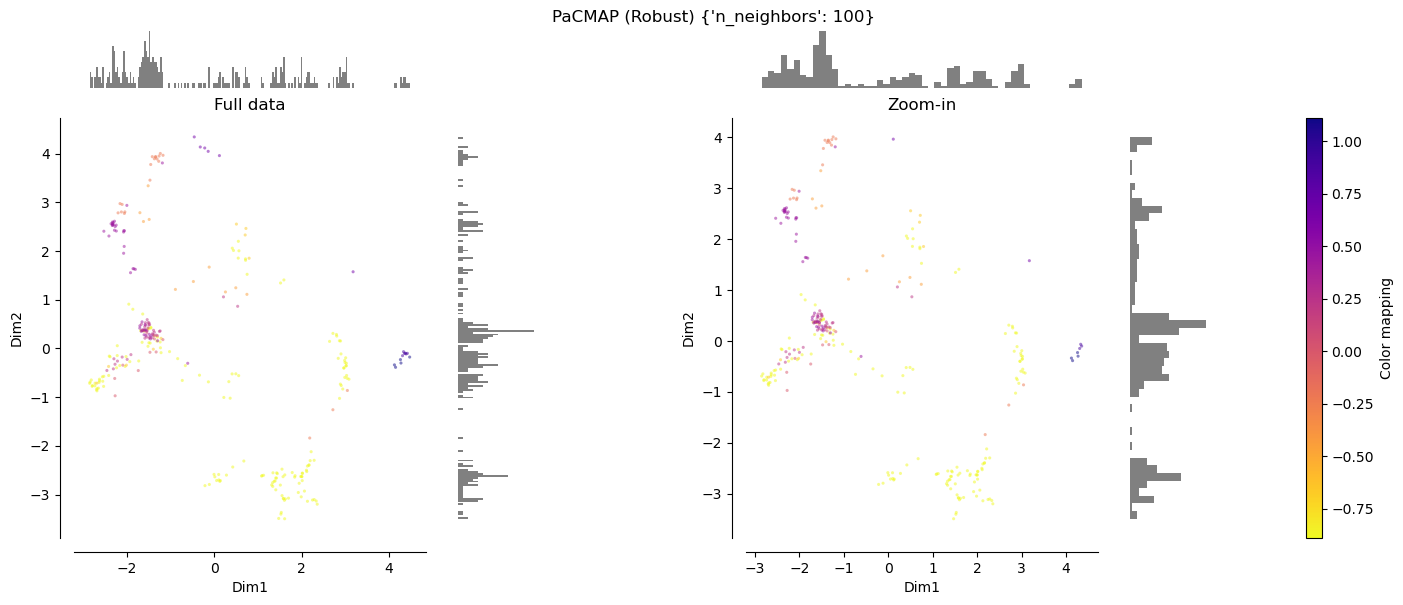

Sample size cannot accommodate number of further pairs requested. n_FP will be reduced.


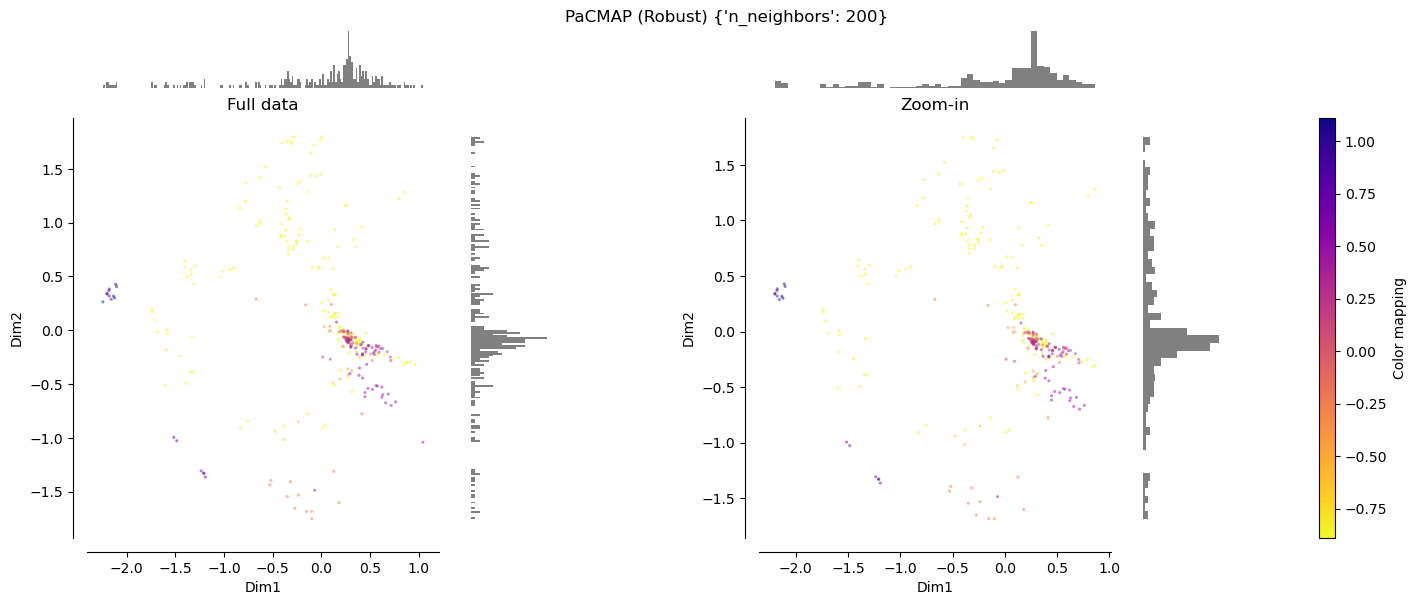

In [24]:
# PaCMAP
for scale_name in scaled_data.keys():
    X_scaled = scaled_data[scale_name]
    y_color = scaled_colors[scale_name]
    print(f"\n=== Масштабирование: {scale_name} ===")
    for params in pacmap_params:
        reducer = pacmap.PaCMAP(n_components=2, random_state=random, **params)
        emb = reducer.fit_transform(X_scaled)
        make_plot(
            emb, y_color,
            title=f"PaCMAP ({scale_name}) {params}",
            feature_names=("Dim1", "Dim2")
        )